In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.use("TkCairo")

In [2]:
## Matplotlib settings
## inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 300,  # to adjust notebook inline plot size
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.5, 2.625], # 4 x 3
#     'figure.figsize': [4*1.125, 3*1.125], # 4x3, full slide in keynote
    'font.family': 'serif',
    'figure.max_open_warning':100,
    'axes.formatter.limits' : [-3, 3]
}
mpl.rcParams.update(params)

## Get physical constants from Scipy
import scipy.constants as con
## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m
# k = con.physical_constants['Boltzmann constant in eV/K'][0]

import scipy.integrate as int

import scipy.io as sio

import scipy.optimize as opt

import scipy.special as spl

In [3]:
misloc_pack_path = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'Mispolarization',
    'python',
#     'gitted',
    )

sys.path.append(misloc_pack_path)

import misloc_mispol_package as mmp
import misloc_mispol_package.calc.coupled_dipoles as cp
import misloc_mispol_package.optics.anal_foc_diff_fields as aff

In [4]:
sys.path.append('..')
import twosphere_temperature as tst
import pti_model as pti

Path to temperature dependent dielectric data

In [5]:
path_to_diel_data = os.path.join(
    os.path.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'DMREF',
    'dielectrics'
    )

In [6]:
os.path.exists(path_to_diel_data)

True

#### System parameters

In [7]:
a1 = 10
# eps_back = 1.473**2
eps_back = 1.473**2

plot_hws = np.linspace(1.8, 2.6, 300)

sensorsize_nm = 1000
ergpers_per_watt = 1e7
cm_per_nm = 1e-7

# pump_intensity = pump_power_watts*ergpers_per_watt/(300*cm_per_nm)**2.
## Define field magnitude from intensity in ergs/(cm^2*s)
# E_pump_mag = ((8*np.pi/c)*pump_intensity)**0.5 
# E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5
## Try Baffou intensity from APL 2009, DOI: 10.1063/1.3116645
pump_intensity_watts_per_cm2 = 1e5/2
pump_power_watts = (
    pump_intensity_watts_per_cm2 * np.pi*(150*cm_per_nm)**2
    )
E_pump_mag = (pump_power_watts*ergpers_per_watt)**0.5

## Define probe intensity
probe_power_watts = 1.1*1e-3 
probe_intensity = (
    probe_power_watts*ergpers_per_watt
    /(300*cm_per_nm)**2.
    )
E_probe_mag = ((8*np.pi/c)*probe_intensity)**0.5

probe_enei = 2.5
# probe_enei = anti_enei
b1 = 5

## Assign material porperties of gold
# au_eps_inf=9.82335326  # eps_inf
# au_w_p=9.06705560/hbar  # w_p
# au_gamma=0.0334860149/hbar  # gamma
## BEM Drude parameters
au_eps_inf=10  # eps_inf
au_w_p=9.0705/hbar  # w_p
au_gamma=0.0660/hbar  # gamma

kappa_glycerol = 0.292 

m_per_cm = 1e-2
pump_intensity_watts_per_cm2/(m_per_cm)**2

def alpha_1_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
#         eps_inf=14.2, 
#         w_p=10.0/hbar, 
#         gamma=0.20/hbar,
#         eps_b=1.33**2., 
        a=a1*1e-7, 
        eps_inf=au_eps_inf,  # eps_inf
        w_p=au_w_p,  # w_p
        gamma=au_gamma,  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )

sphere_1_absorption = cp.single_dip_absorption(
    mol_angle=0,
    E_d_angle=0,
    alpha_0_p0=alpha_1_of_hw(plot_hws),
    drive_hbar_w=plot_hws,
    drive_amp=E_pump_mag,
    n_b=eps_back**0.5,)

## Find mode energies
bond_enei = plot_hws[np.argmax(sphere_1_absorption)]

# Calculate coupled abs for pump excitation

eps_at_bond = cp.drude_model(
    w=bond_enei/hbar, 
    eps_inf=au_eps_inf,  # eps_inf
    w_p=au_w_p,  # w_p
    gamma=au_gamma,)

## Back to calcs
bond_alpha_1 = alpha_1_of_hw(bond_enei)
# bond_alpha_2 = alpha_2_of_hw(bond_enei)

obs_points = np.linspace(-sensorsize_nm/2, sensorsize_nm/2, 100)*1e-7

bond_p1_pumped, = cp.single_dip_mag_focused_beam(
    angle=0,
    p0_position= np.array([0, 0, 0]),
    beam_x_positions=obs_points,
    E_d_angle=0,
    drive_hbar_w=bond_enei,
    alpha0_diag=alpha_1_of_hw(bond_enei),
    n_b=eps_back**0.5,
    drive_amp=E_pump_mag,
    return_polarizabilities=False,)

bond_p1_pumped_pow_cgs = cp.power_absorped(
    bond_p1_pumped, 
    alpha_1_of_hw(bond_enei),
    bond_enei,
    n_b=eps_back**0.5)


## Convert powers to SI
bond_p1_pumped_pow_si = bond_p1_pumped_pow_cgs/ergpers_per_watt
# anti_p1_pumped_pow_si = anti_p1_pumped_pow_cgs/ergpers_per_watt


## Calculate temperatures
sph_1_area_si = 4*np.pi*(a1*1e-9)**2.
bond_flux_1 = bond_p1_pumped_pow_si / sph_1_area_si
bond_temps = bond_flux_1*(a1*1e-9)/kappa_glycerol


##### Build PTImages
heated_particle = pti.single_particle_image(
    probe_enei, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag,
    eps0=eps_back)

## Calculate confocal image

conf_img_n1p473_dndt_5p8 = heated_particle.conf_PTI(
    obs_points*1e7, 
    probe_enei, 
    T1=bond_temps, 
    b1=a1+b1, 
    particle_position=0, 
    a1=a1, 
    )


Load n and k data and convert to epsilon

In [26]:
## Initialize dictionaries to hold the datas
hw_n_T_dict = {}
hw_eps_T_dict = {}

## loop through temperatures to store n&k and calculate epsilon
for i in range(0, 100):
    lambda_n_and_k = np.loadtxt(
        os.path.join(path_to_diel_data, f'au_Conor_{i:d}K.txt'),
        skiprows=3
        )
    ## Data is in DDA format, meaning 
    ## wavelengths in micron, n, k
    lambda_n_and_k[:, 0] *= 1e3 ## nm per micron
    
    n_compl = lambda_n_and_k[:, 1] + 1j*lambda_n_and_k[:, 2]

    ## Assuming epsilon = (n + ik)^2
    hbarw_diel, eps_0K = (
        1240/lambda_n_and_k[:, 0],
        (n_compl)**2.
        )
    
    ## Store data in dictionaries
    hw_eps_T_dict[f'hw_eps_{i:d}K'] = np.vstack((hbarw_diel, eps_0K))
    hw_n_T_dict[f'hw_n_{i:d}K'] = np.vstack((hbarw_diel, n_compl))

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$\\hbar\\omega$ [nm]')

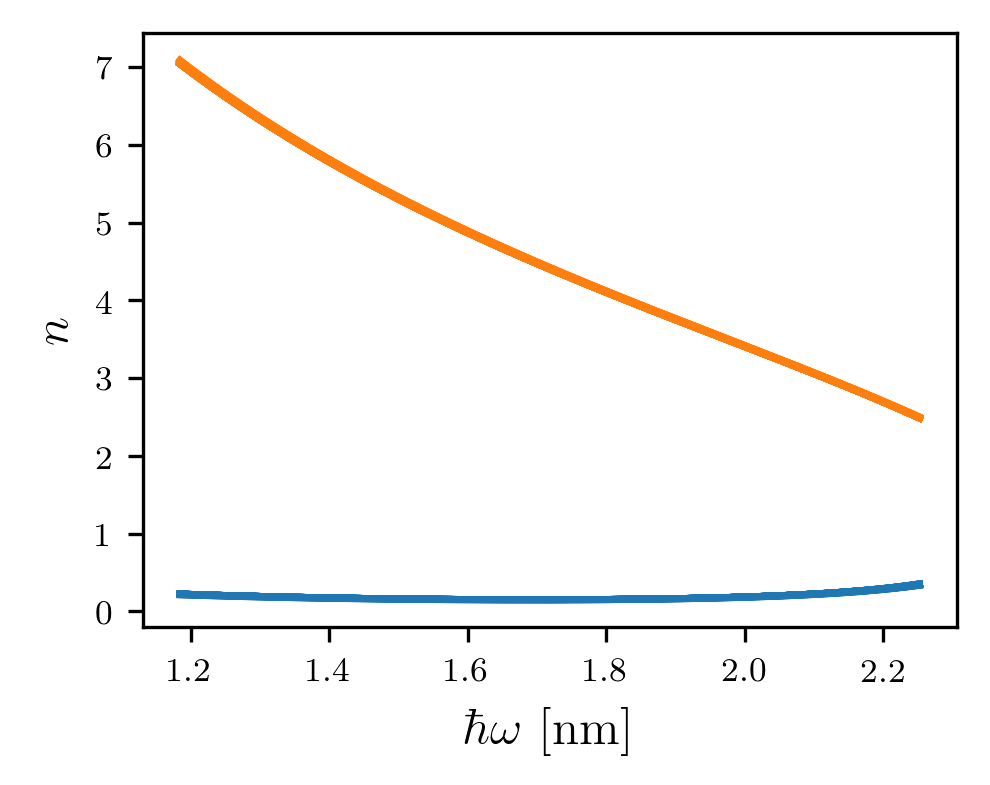

In [68]:
## Plot n and k (real and imaginary parts of n)

for i in range(100):
    plt.plot(hw_n_T_dict[f'hw_n_{i:d}K'][0], np.real(hw_n_T_dict[f'hw_n_{i:d}K'][1]), c='C0',  alpha=i/100)
    plt.plot(hw_n_T_dict[f'hw_n_{i:d}K'][0], np.imag(hw_n_T_dict[f'hw_n_{i:d}K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$n$')
plt.xlabel(r'$\hbar\omega$ [nm]')


Text(0.5, 0, '$\\hbar\\omega$ [nm]')

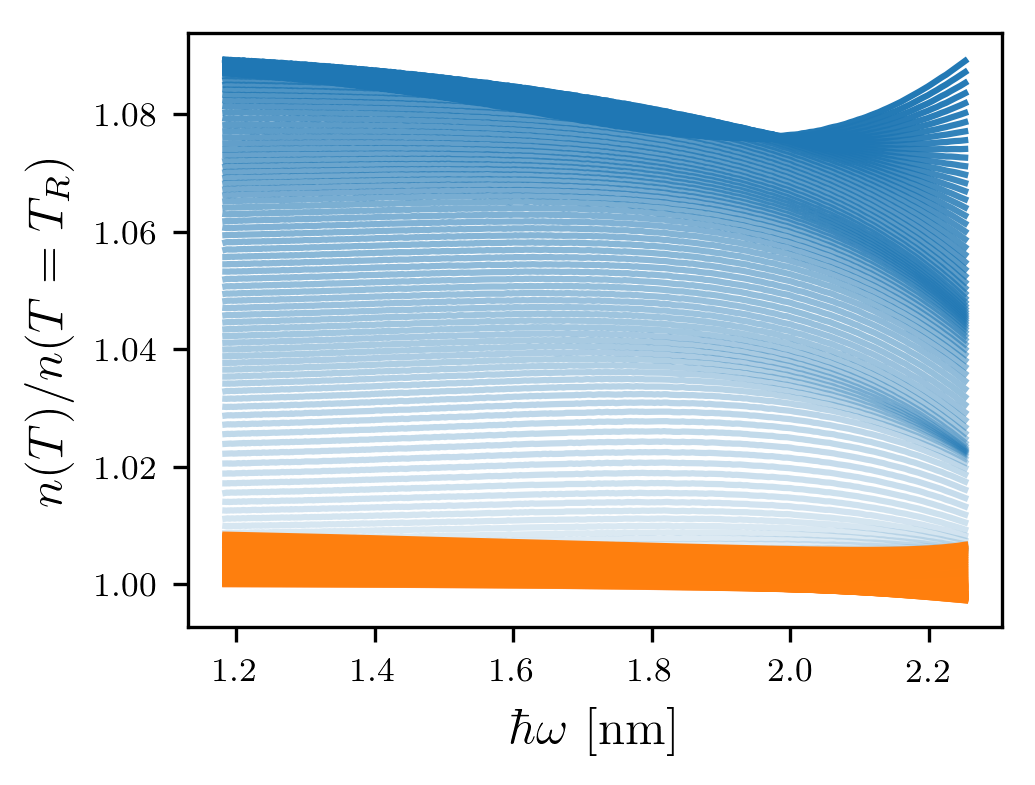

In [145]:
## Plot 

for i in range(100):
    plt.plot(
        hw_n_T_dict[f'hw_n_{i:d}K'][0].real, 
        np.real(hw_n_T_dict[f'hw_n_{i:d}K'][1])/np.real(hw_n_T_dict[f'hw_n_0K'][1]), 
        c='C0',  alpha=i/100)
    plt.plot(
        hw_n_T_dict[f'hw_n_{i:d}K'][0].real, 
        np.imag(hw_n_T_dict[f'hw_n_{i:d}K'][1])/np.imag(hw_n_T_dict[f'hw_n_0K'][1]), 
        c='C1',  alpha=i/100)
    
plt.ylabel(r'$n(T)/n(T=T_R)$')
plt.xlabel(r'$\hbar\omega$ [nm]')


## Try plotting dn/dt

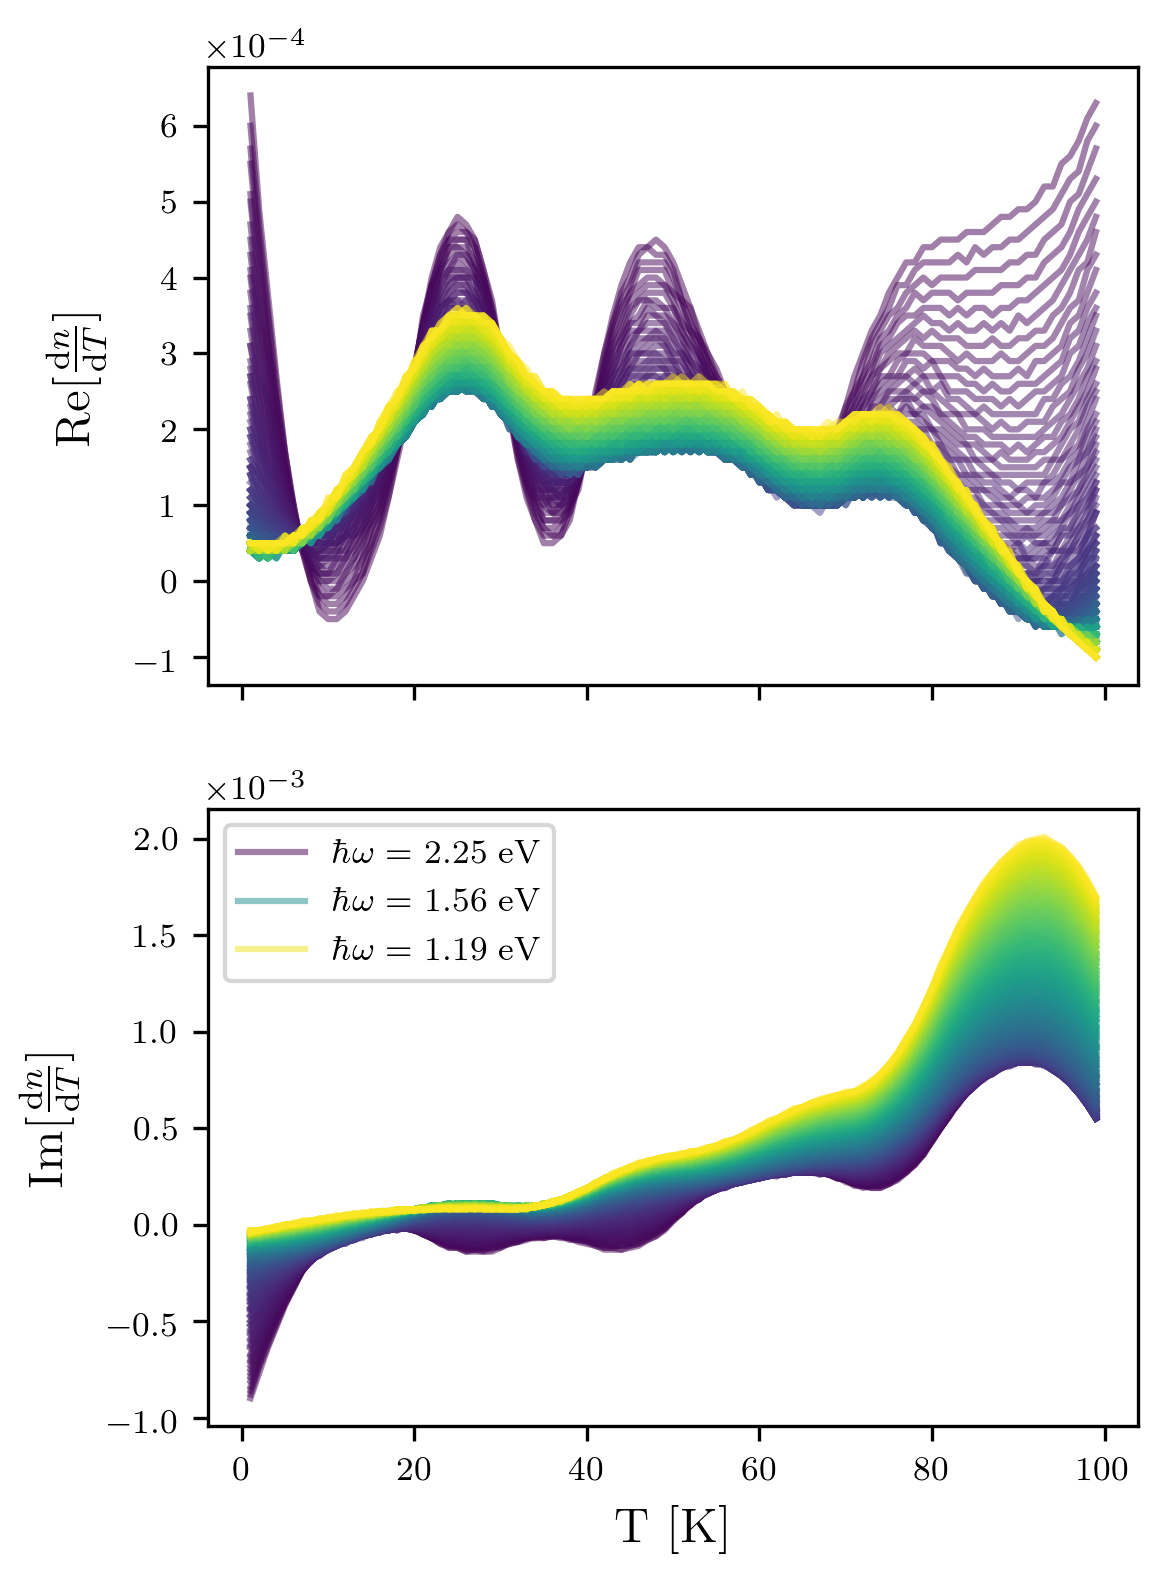

In [148]:
## Get all n data into array to calculate finite difference derivitive

## Real part first
## ---------------
## Initialize array: rows correspond to wavelengths, columns to temperatures
nr_array = np.zeros((
    len(hw_n_T_dict[f'hw_n_0K'][0])+1, 101
    )) 

## use first column and row for labels
nr_array[1:, 0] = hw_n_T_dict[f'hw_n_0K'][0].real
nr_array[0, 1:] = np.linspace(0, 99, 100)

## Populate array with n values from dictionary
for i in range(100):
    nr_array[1:, i+1] = hw_n_T_dict[f'hw_n_{i:d}K'][1].real

## Calculate finite difference
dnr_dt_array = np.diff(nr_array[:, 1:], axis=1)
## -------------------


## Then Imaginary part
## -------------------
ni_array = np.zeros((
    len(hw_n_T_dict[f'hw_n_0K'][0])+1, 101
    )) 

## use first column and row for labels
ni_array[1:, 0] = hw_n_T_dict[f'hw_n_0K'][0].real
ni_array[0, 1:] = np.linspace(0, 99, 100)

## Populate array with n values from dictionary    
for i in range(100):
    ni_array[1:, i+1] = hw_n_T_dict[f'hw_n_{i:d}K'][1].imag

## Calculate finite difference
dni_dt_array = np.diff(ni_array[:, 1:], axis=1)
## -------------------


## Build figure
## ------------
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,6))

## Loop through tempertures of Re[n]
for i, row in enumerate(dnr_dt_array):
    if i is 0:
        continue
    ## Grab a fre frequencl labels for legend
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\hbar\omega = $'+f' {nr_array[i, 0]:.2f} eV'
    else: label=None
    
    axs[0].plot(
        nr_array[0, 2:], 
        row, 
        label=label,
        c=mpl.cm.viridis(i/296), 
        alpha=.5)

## Loop through tempertures of Im[n]
for i, row in enumerate(dni_dt_array):
    if i is 0:
        continue
        ## Grab a fre frequencl labels for legend
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\hbar\omega = $'+f' {ni_array[i, 0]:.2f} eV'
    else: label=None
        
    axs[1].plot(
        ni_array[0, 2:], 
        row, 
        c=mpl.cm.viridis(i/296), 
        label=label,
        alpha=.5)


axs[0].set_ylabel(r'$\mathrm{Re}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_ylabel(r'$\mathrm{Im}[\frac{\mathrm{d}n}{\mathrm{d}T}]$')
axs[1].set_xlabel('T [K]')
axs[1].legend()

#### plot dn_dt / n to compare to what I was doing before

In [135]:
dnr_dt_array[:, 1:].shape

(296, 100)

In [133]:
np.diff(dnr_dt_array[:, 1:], axis=1).shape

(296, 99)

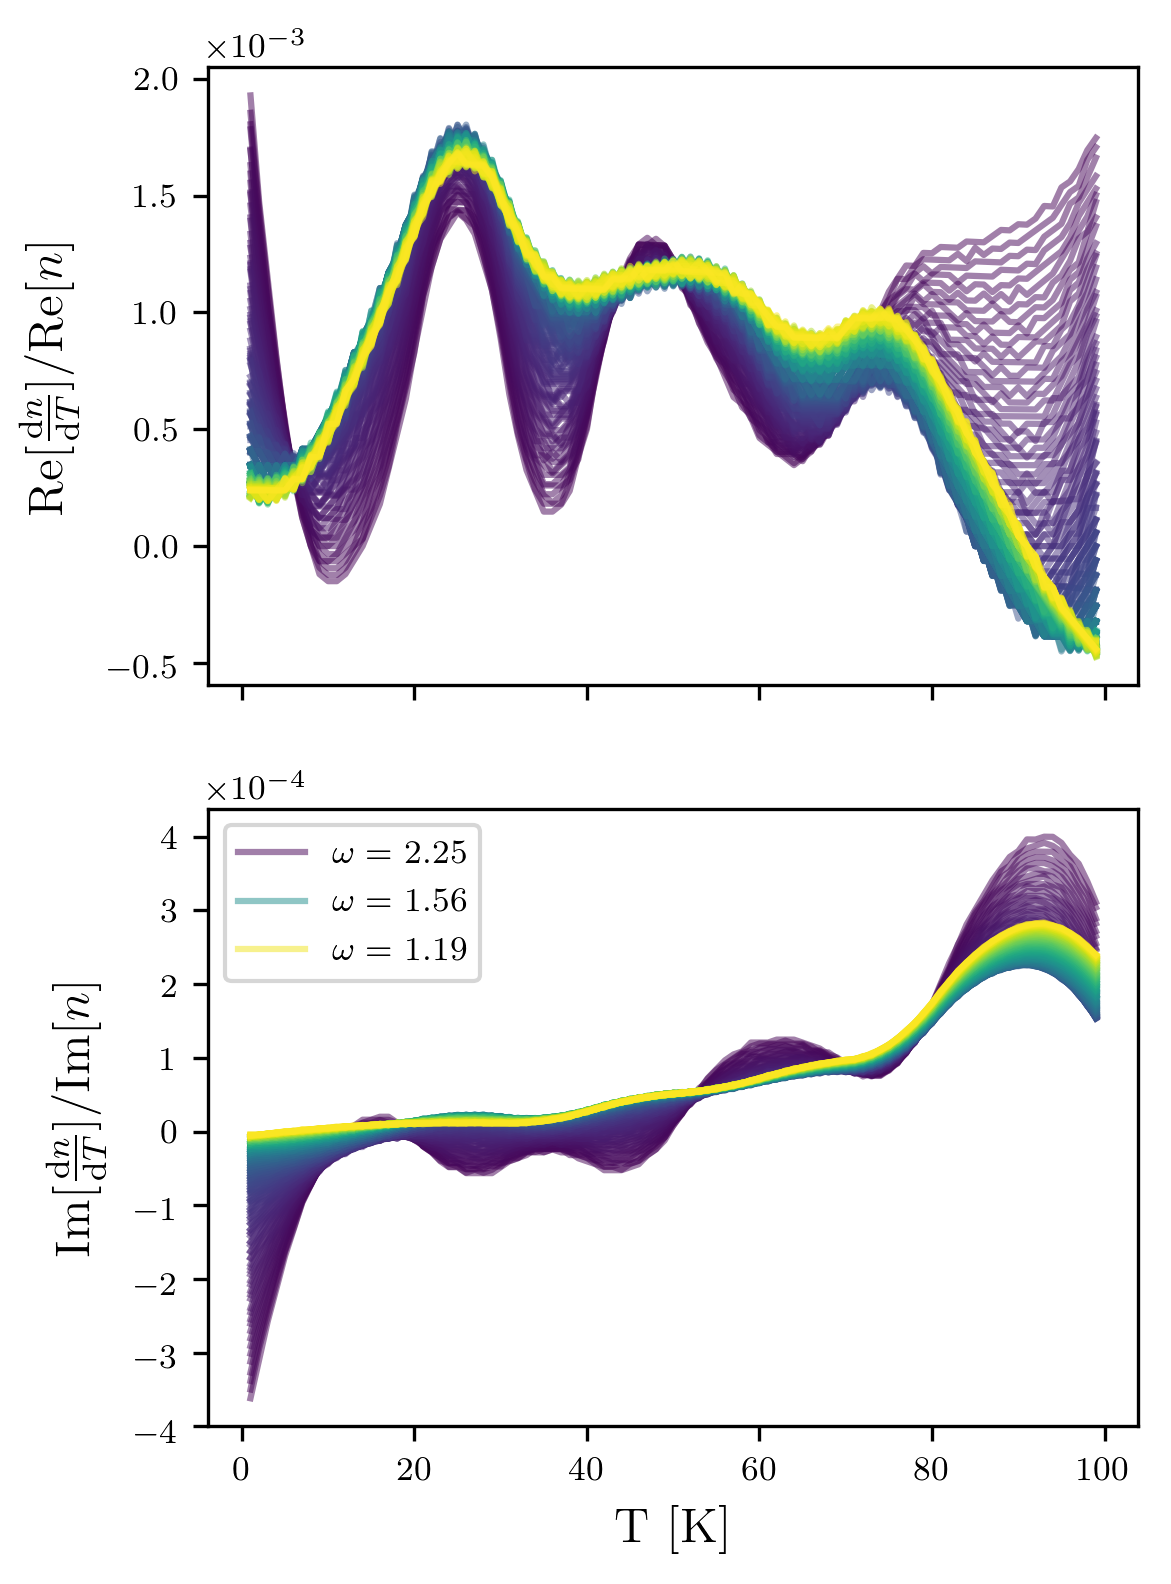

In [143]:

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,6))

for i, row in enumerate(np.diff(dnr_dt_array[:, 1:], axis=1)):
    if i is 0:
        continue       
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\omega = $'+f' {dnr_dt_array[i, 0]:.2f}'
    else: label=None
        
    axs[0].plot(
        dnr_dt_array[0, 2:], 
        row / dnr_dt_array[i, 2:], 
        label=label,
        c=mpl.cm.viridis(i/296), 
        alpha=.5)

for i, row in enumerate(np.diff(dni_dt_array[:, 1:], axis=1)):
    if i is 0:
        continue    
    if ((i == 1) or (i == 145) or (i == 290)):
        label = r'$\omega = $'+f' {dni_dt_array[i, 0]:.2f}'
    else: label=None
        
    axs[1].plot(
        dni_dt_array[0, 2:], 
        row / dni_dt_array[i, 2:], 
        c=mpl.cm.viridis(i/296), 
        label=label,
        alpha=.5)


axs[0].set_ylabel(r'$\mathrm{Re}[\frac{\mathrm{d}n}{\mathrm{d}T}]/\mathrm{Re}[n]$')
axs[1].set_ylabel(r'$\mathrm{Im}[\frac{\mathrm{d}n}{\mathrm{d}T}]/\mathrm{Im}[n]$')
axs[1].set_xlabel('T [K]')
axs[1].legend()

## dielectric function 

/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


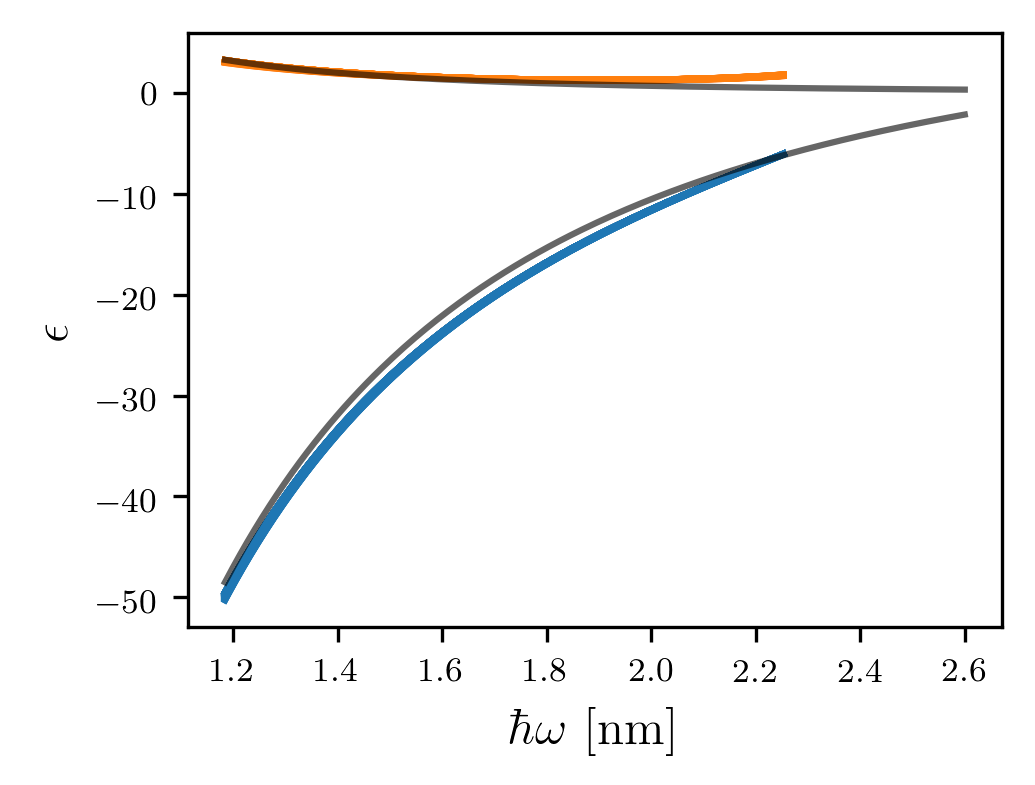

In [9]:
for i in range(100):
    plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C0',  alpha=i/100)
    plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')


hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)
drude_model = cp.drude_model(hw_h/hbar, eps_inf=au_eps_inf, w_p=au_w_p, gamma=au_gamma)
plt.plot(
    hw_h,
    np.real(drude_model),
    c = 'k',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(drude_model),
    c = 'k',
    alpha=.6
    )

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

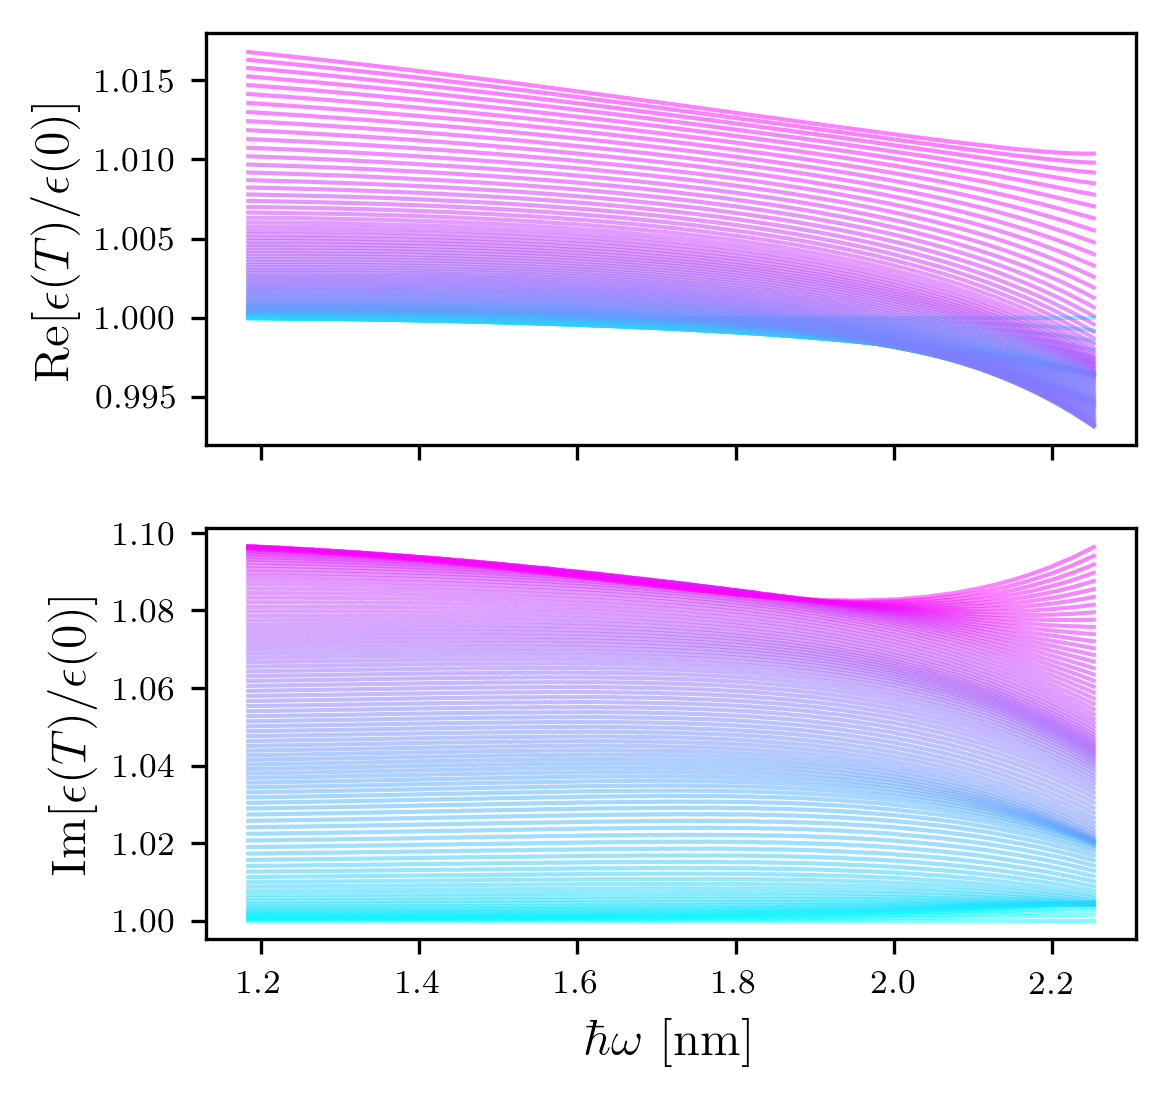

In [69]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))
for i in range(100):
    axs[0].plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1])/np.real(hw_eps_T_dict[f'hw_eps_0K'][1]), 
        lw=1,
        c=plt.cm.cool(i/100),  alpha=.5)
    axs[1].plot(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
        np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1])/np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]), 
        lw=1,
        c=plt.cm.cool(i/100),  alpha=.5)
    
# axs[0].plot(
#     hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
#     np.real(drude_model)/np.real(hw_eps_T_dict[f'hw_eps_0K'][1]),
#     c = 'k',
#     alpha=.6
#     )
# axs[1].plot(
#     hw_eps_T_dict[f'hw_eps_{i:d}K'][0], 
#     np.imag(drude_model)/np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]),
#     c = 'k',
#     alpha=.6
#     )
    
axs[0].set_ylabel(r'Re[$\epsilon(T)/\epsilon(0)$]')
axs[1].set_ylabel(r'Im[$\epsilon(T)/\epsilon(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')

Then I'd like to compare the polarizability at different temperatures, or even spectra

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

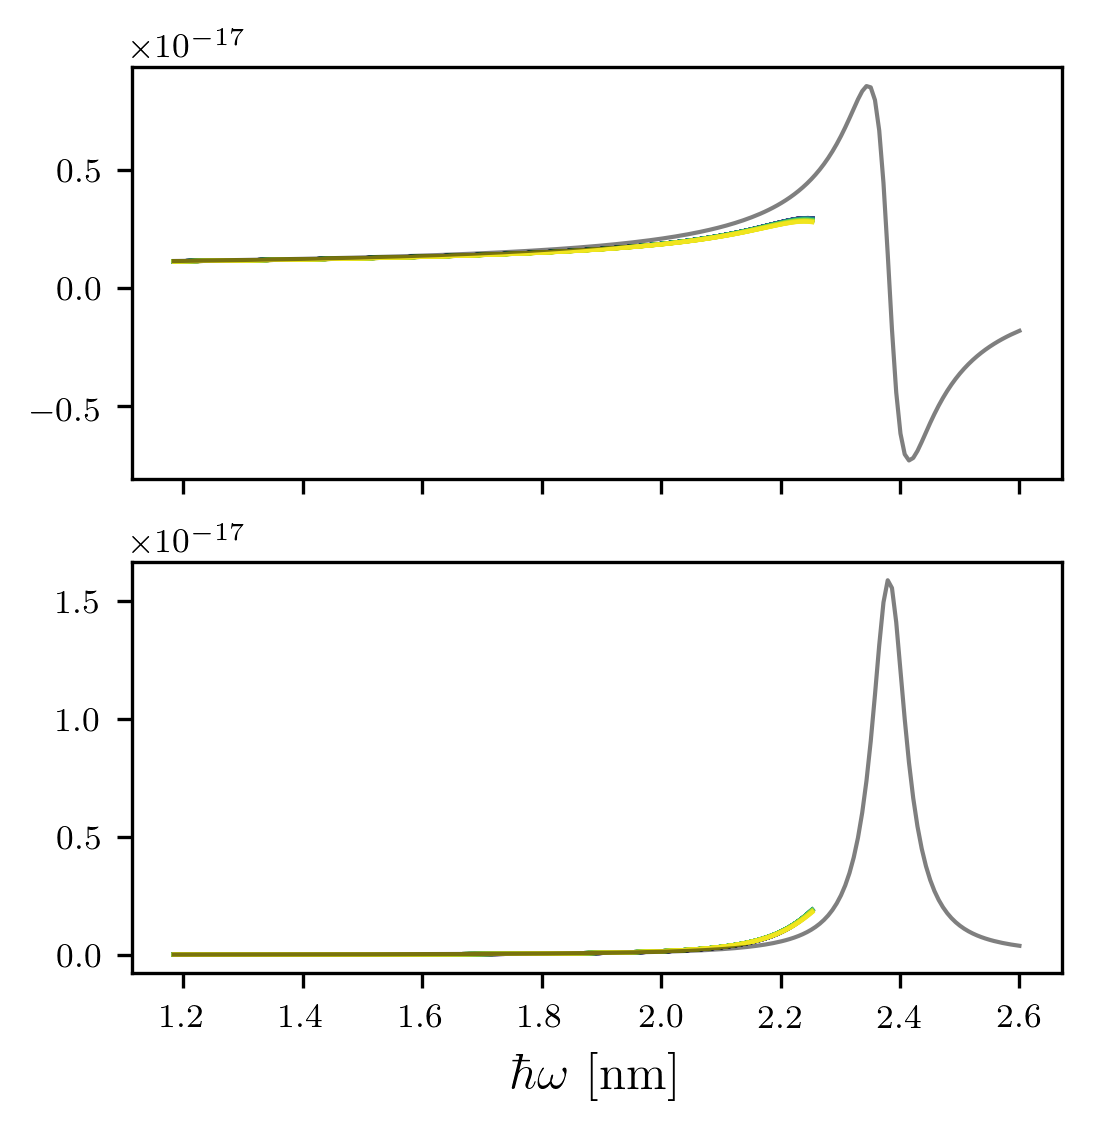

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]
    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)

alpha_Drude = alpha_1_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')



/Users/chair/anaconda/envs/py36/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, '$\\hbar\\omega$ [nm]')

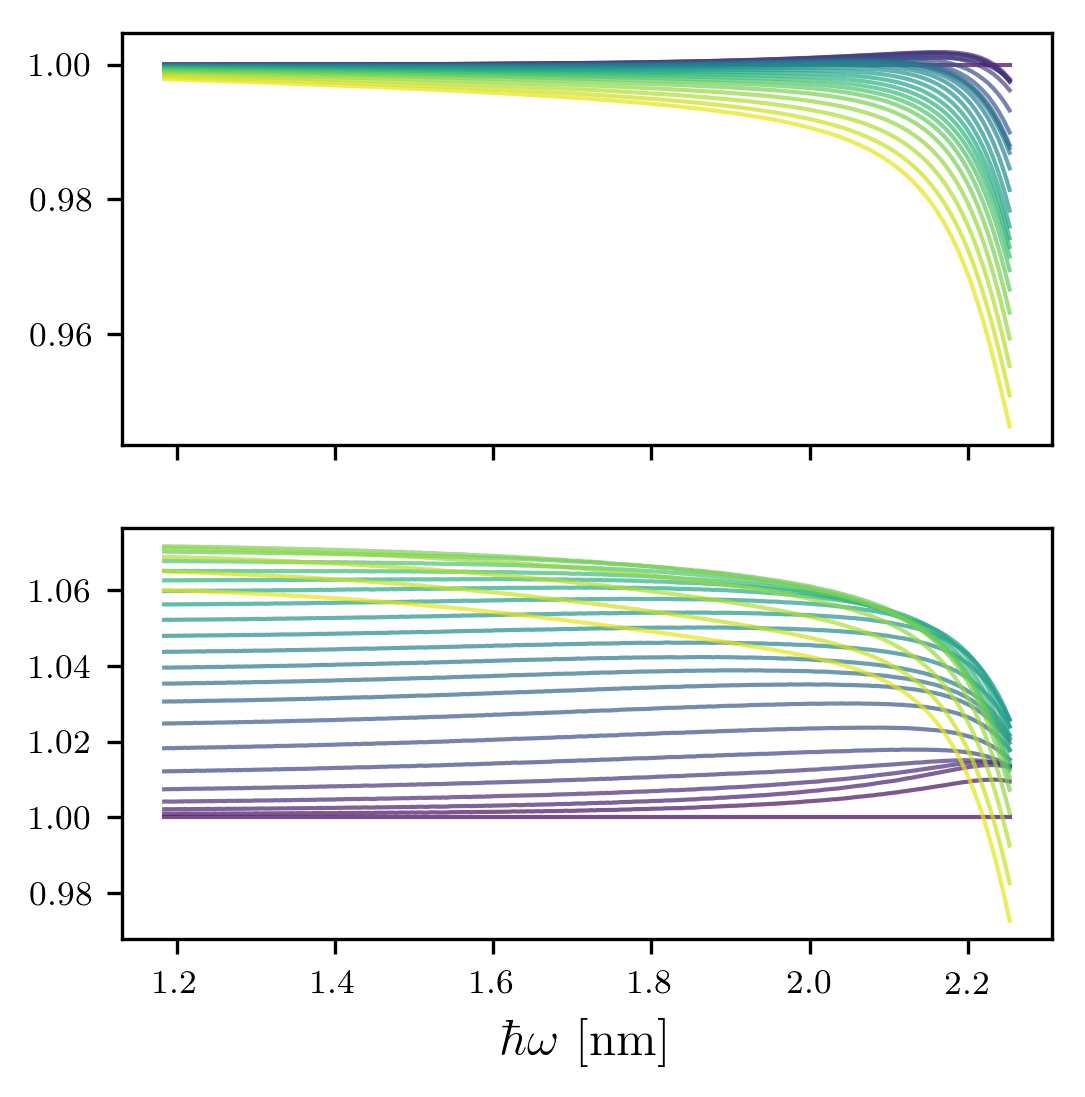

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

alpha_of0K = cp.sparse_sphere_polarizability_Mie(
    hw_eps_T_dict[f'hw_eps_0K'][1],
    eps_b=eps_back,
    a=a1*1e-7,
    w=hw_eps_T_dict[f'hw_eps_0K'][0],
    )[:, 0,0]
    
for i in range(100):

    if i % 4 is not 0:
        continue
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]

    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT)/np.real(alpha_of0K), 
        lw=1,
        c=plt.cm.viridis(i/100),  
        alpha=.7,
        )
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT)/np.imag(alpha_of0K), 
        lw=1,
        c=plt.cm.viridis(i/100),  
        alpha=.7,
        )

# alpha_Drude = alpha_1_of_hw(hw)[:, 0,0]

# axs[0].plot(
#     hw, 
#     np.real(alpha_Drude), 
#     lw=1,
#     c='k',  alpha=.5)
# axs[1].plot(
#     hw, 
#     np.imag(alpha_Drude), 
#     lw=1,
#     c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')




Try fitting a drude model to the 0K data

In [13]:
fit_cutoff = 1.8

def drude_cost(param, *args):

    eps_inf, w_p, gamma = param
    
    hw, data = args
    
    model = cp.drude_model(hw/hbar, eps_inf=eps_inf, w_p=w_p, gamma=gamma)

    res = (model - data)*(hw>fit_cutoff)
    
    return np.array([res.real, res.imag]).ravel()
    

In [14]:
ini_params = [au_eps_inf, au_w_p, au_gamma]

drude_fit_0K = opt.least_squares(
    drude_cost,
    ini_params,
    args=(hw_eps_T_dict[f'hw_eps_0K'][0], hw_eps_T_dict[f'hw_eps_0K'][1]),
    x_scale=[1e2, 1e16, 1e14]
    )

In [15]:
ini_params

[10, 1.378051550219846e+16, 100271652405611.44]

In [16]:
drude_fit_0K['x']

array([1.24001986e+01, 1.48536639e+16, 1.53546178e+14])

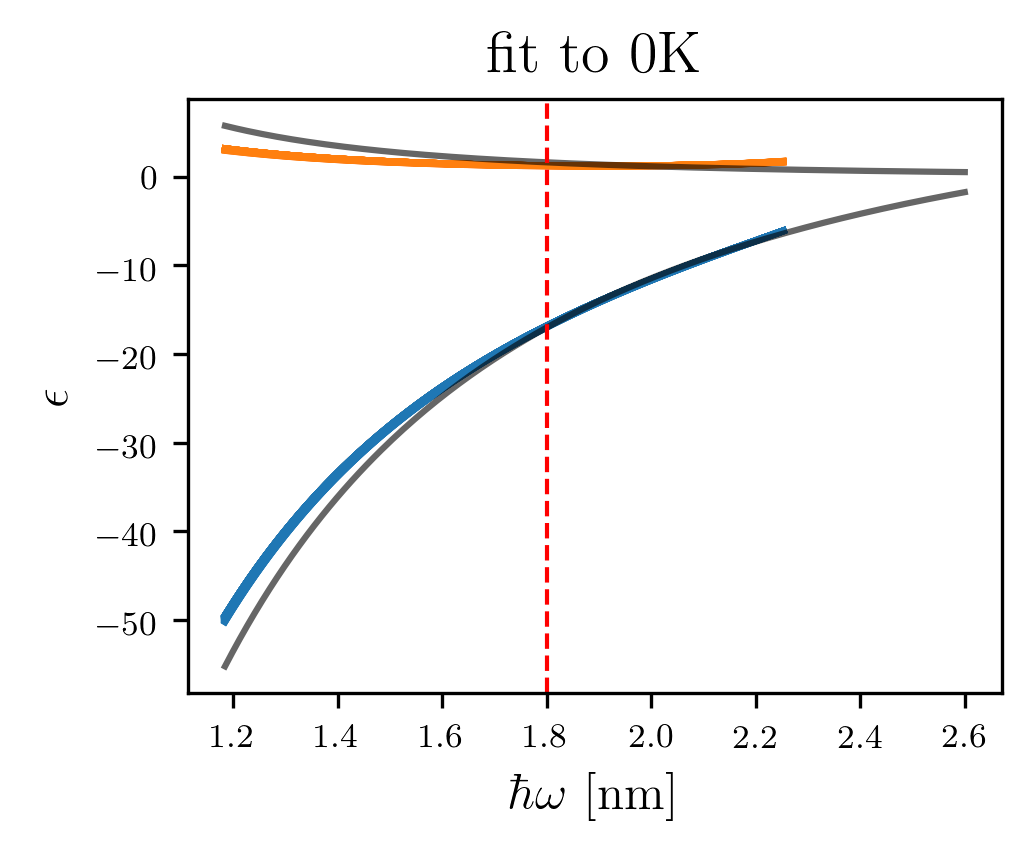

In [17]:

for i in range(100):
    plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C0',  alpha=i/100)
    plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')


hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)
fit_drude =  cp.drude_model(hw_h/hbar, *drude_fit_0K['x'])
plt.plot(
    hw_h,
    np.real(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.title('fit to 0K')
plt.axvline(fit_cutoff, c='red', lw=1, ls='--')

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

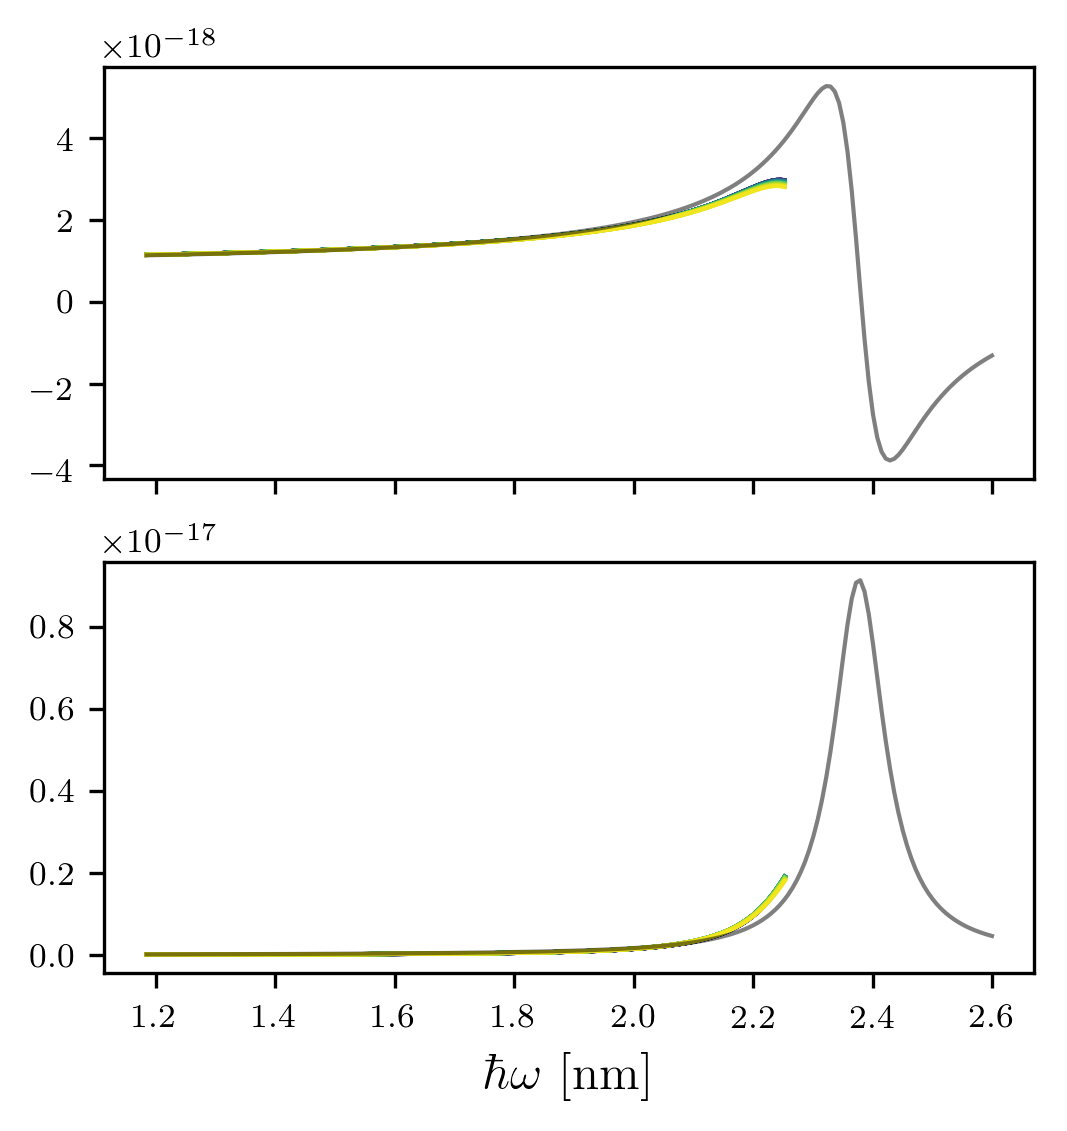

In [18]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]
    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)

def alpha_fitDrude_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        a=a1*1e-7, 
        eps_inf=drude_fit_0K['x'][0],  # eps_inf
        w_p=drude_fit_0K['x'][1],  # w_p
        gamma=drude_fit_0K['x'][2],  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )
alpha_Drude = alpha_fitDrude_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')



In [19]:
fit_cutoff = 2

def drude_cost(param, *args):

    eps_inf, w_p, gamma = param
    
    hw, data = args
    
    model = cp.drude_model(hw/hbar, eps_inf=eps_inf, w_p=w_p, gamma=gamma)

    res = (model - data)*(hw>fit_cutoff)
    
    return np.array([res.real, res.imag]).ravel()
    

In [20]:
ini_params = [au_eps_inf, au_w_p, au_gamma]

drude_fit_0K = opt.least_squares(
    drude_cost,
    ini_params,
    args=(hw_eps_T_dict[f'hw_eps_0K'][0], hw_eps_T_dict[f'hw_eps_0K'][1]),
    x_scale=[1e2, 1e16, 1e14]
    )

In [21]:
ini_params

[10, 1.378051550219846e+16, 100271652405611.44]

In [22]:
drude_fit_0K['x']

array([1.41833947e+01, 1.54744189e+16, 1.86252401e+14])

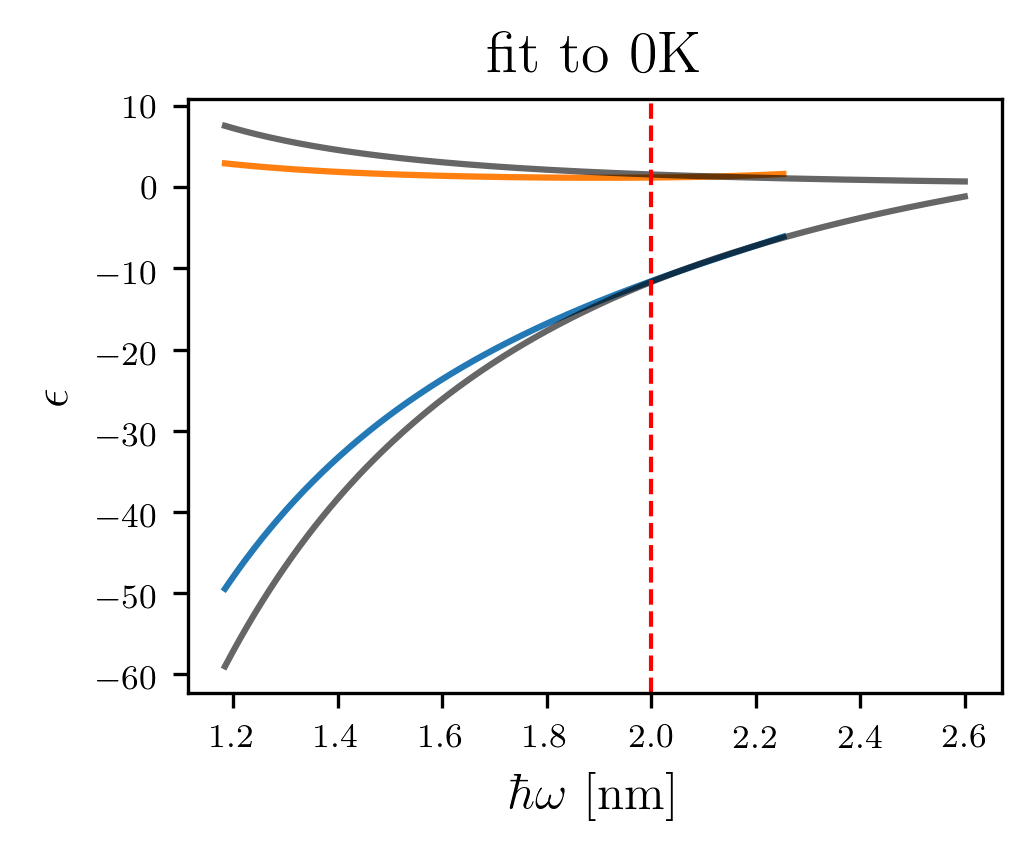

In [23]:

# for i in range(100):
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C0',  alpha=i/100)
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C1',  alpha=i/100)
# for i in range(100):
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.real(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C0',  alpha=i/100)
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')


hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)
fit_drude =  cp.drude_model(hw_h/hbar, *drude_fit_0K['x'])
plt.plot(
    hw_h,
    np.real(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.title('fit to 0K')
plt.axvline(fit_cutoff, c='red', lw=1, ls='--')

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

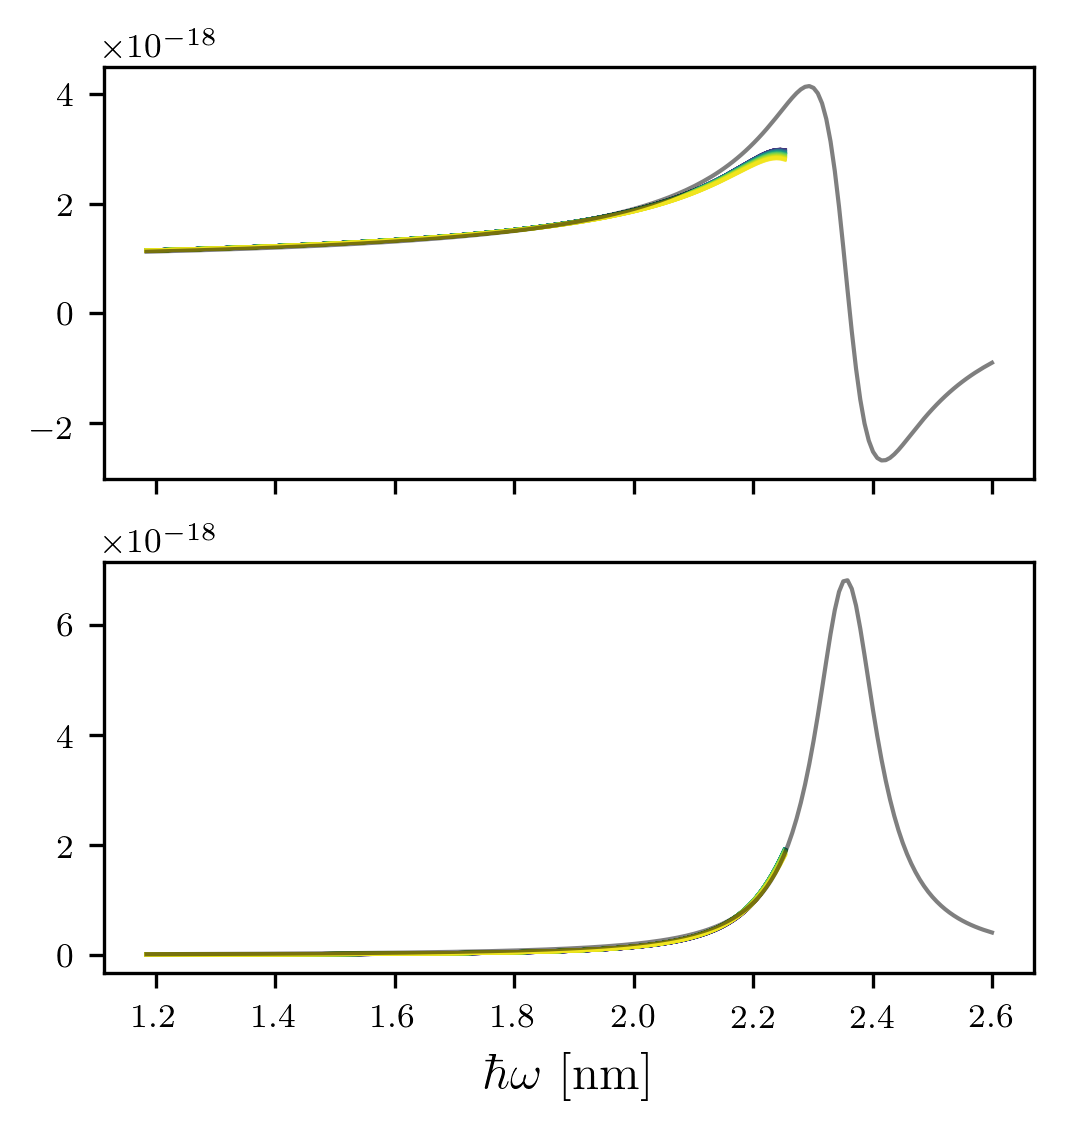

In [24]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]
    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)

def alpha_fitDrude_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        a=a1*1e-7, 
        eps_inf=drude_fit_0K['x'][0],  # eps_inf
        w_p=drude_fit_0K['x'][1],  # w_p
        gamma=drude_fit_0K['x'][2],  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )
alpha_Drude = alpha_fitDrude_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')



In [25]:
fit_cutoff = 2.22

def drude_cost(param, *args):

    eps_inf, w_p, gamma = param
    
    hw, data = args
    
    model = cp.drude_model(hw/hbar, eps_inf=eps_inf, w_p=w_p, gamma=gamma)

    res = (model - data)*(hw>fit_cutoff)
    
    return np.array([res.real, res.imag]).ravel()
    

In [26]:
ini_params = [au_eps_inf, au_w_p, au_gamma]

drude_fit_0K = opt.least_squares(
    drude_cost,
    ini_params,
    args=(hw_eps_T_dict[f'hw_eps_0K'][0], hw_eps_T_dict[f'hw_eps_0K'][1]),
    x_scale=[1e2, 1e16, 1e14]
    )

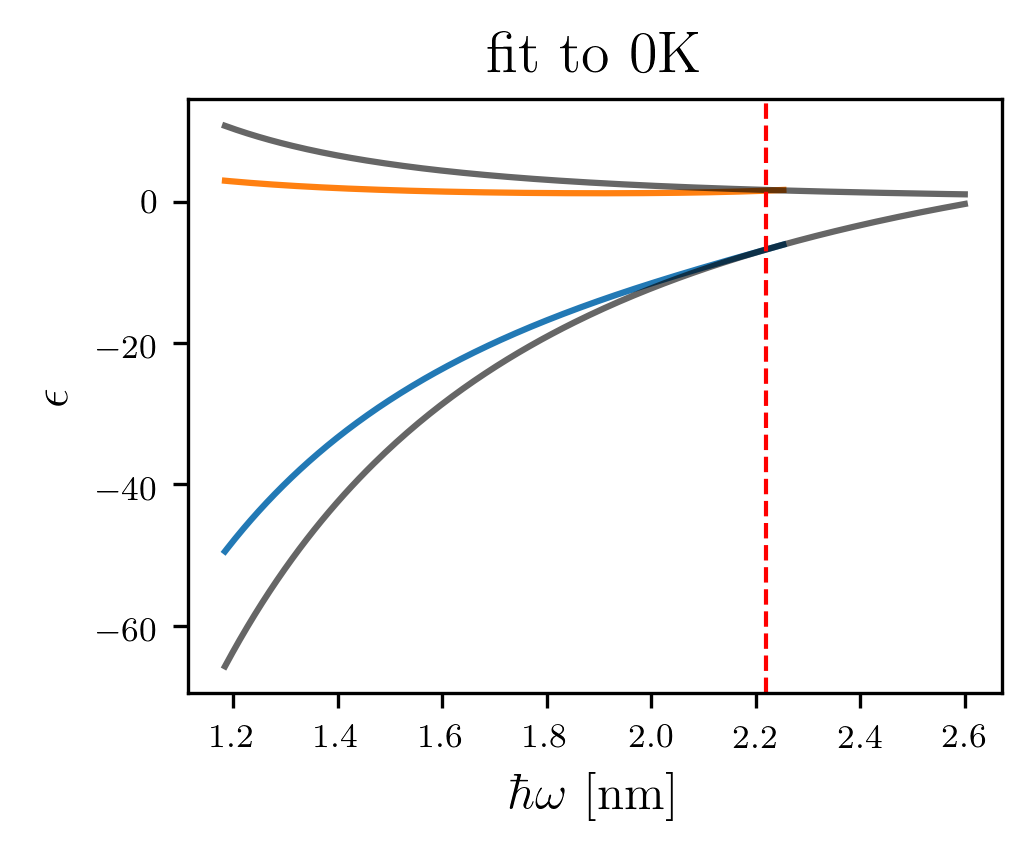

In [27]:

# for i in range(100):
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.real(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C0',  alpha=i/100)
#     plt.plot(hw_eps_T_dict[f'hw_eps_{i:d}K'][0], np.imag(hw_eps_T_dict[f'hw_eps_{i:d}K'][1]), c='C1',  alpha=i/100)
# for i in range(100):
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.real(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C0',  alpha=i/100)
plt.plot(hw_eps_T_dict[f'hw_eps_0K'][0], np.imag(hw_eps_T_dict[f'hw_eps_0K'][1]), c='C1',  alpha=i/100)
    
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\hbar\omega$ [nm]')


hw_h = np.linspace(hw_eps_T_dict[f'hw_eps_{i:d}K'][0].min(), 2.6, 200)
fit_drude =  cp.drude_model(hw_h/hbar, *drude_fit_0K['x'])
plt.plot(
    hw_h,
    np.real(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.plot(
    hw_h,
    np.imag(fit_drude),
    c = 'k',
    alpha=.6
    )
plt.title('fit to 0K')
plt.axvline(fit_cutoff, c='red', lw=1, ls='--')

Text(0.5, 0, '$\\hbar\\omega$ [nm]')

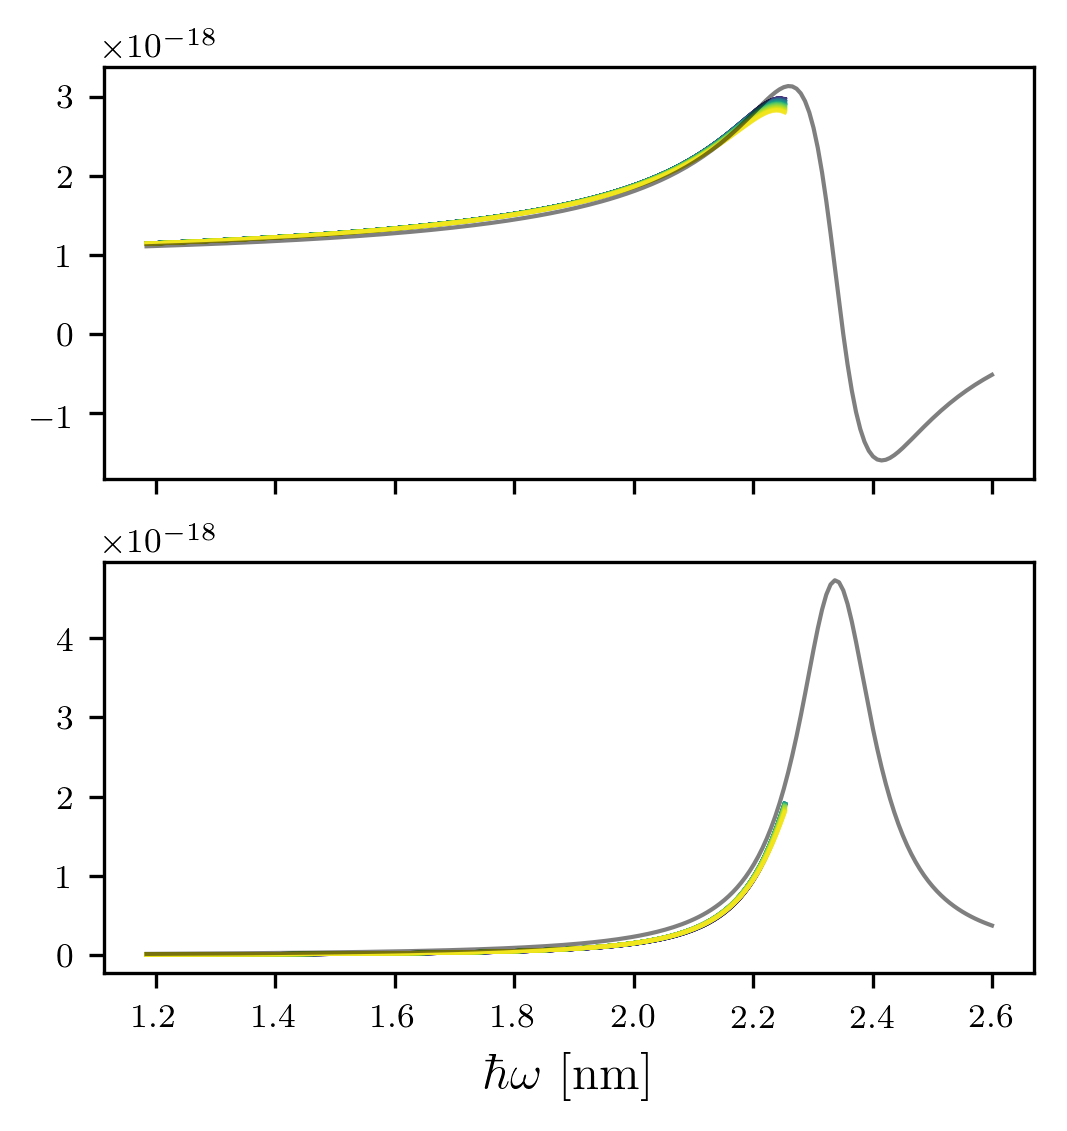

In [28]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    alpha_ofT = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw,
        )[:, 0,0]
    
    axs[0].plot(
        hw, 
        np.real(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)
    axs[1].plot(
        hw, 
        np.imag(alpha_ofT), 
        lw=1,
        c=plt.cm.viridis(i/100),  alpha=.5)

def alpha_fitDrude_of_hw(hw):
    return cp.sparse_Mie_sphere_polarizability_Drude(
        w=hw/hbar, 
        a=a1*1e-7, 
        eps_inf=drude_fit_0K['x'][0],  # eps_inf
        w_p=drude_fit_0K['x'][1],  # w_p
        gamma=drude_fit_0K['x'][2],  # gamma
        eps_b=eps_back,  # eps_b
#         a=41*1e-7
        )
alpha_Drude = alpha_fitDrude_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')



# Compare data to linear taylor expansion I have been using for PTImages

In [29]:
heated_particle = pti.single_particle_image(
    hw_h, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag,
    eps0=eps_back)

In [30]:
linear_alpha_at0K = heated_particle.alpha_of_T(0, b1*1e-7, a1*1e-7)

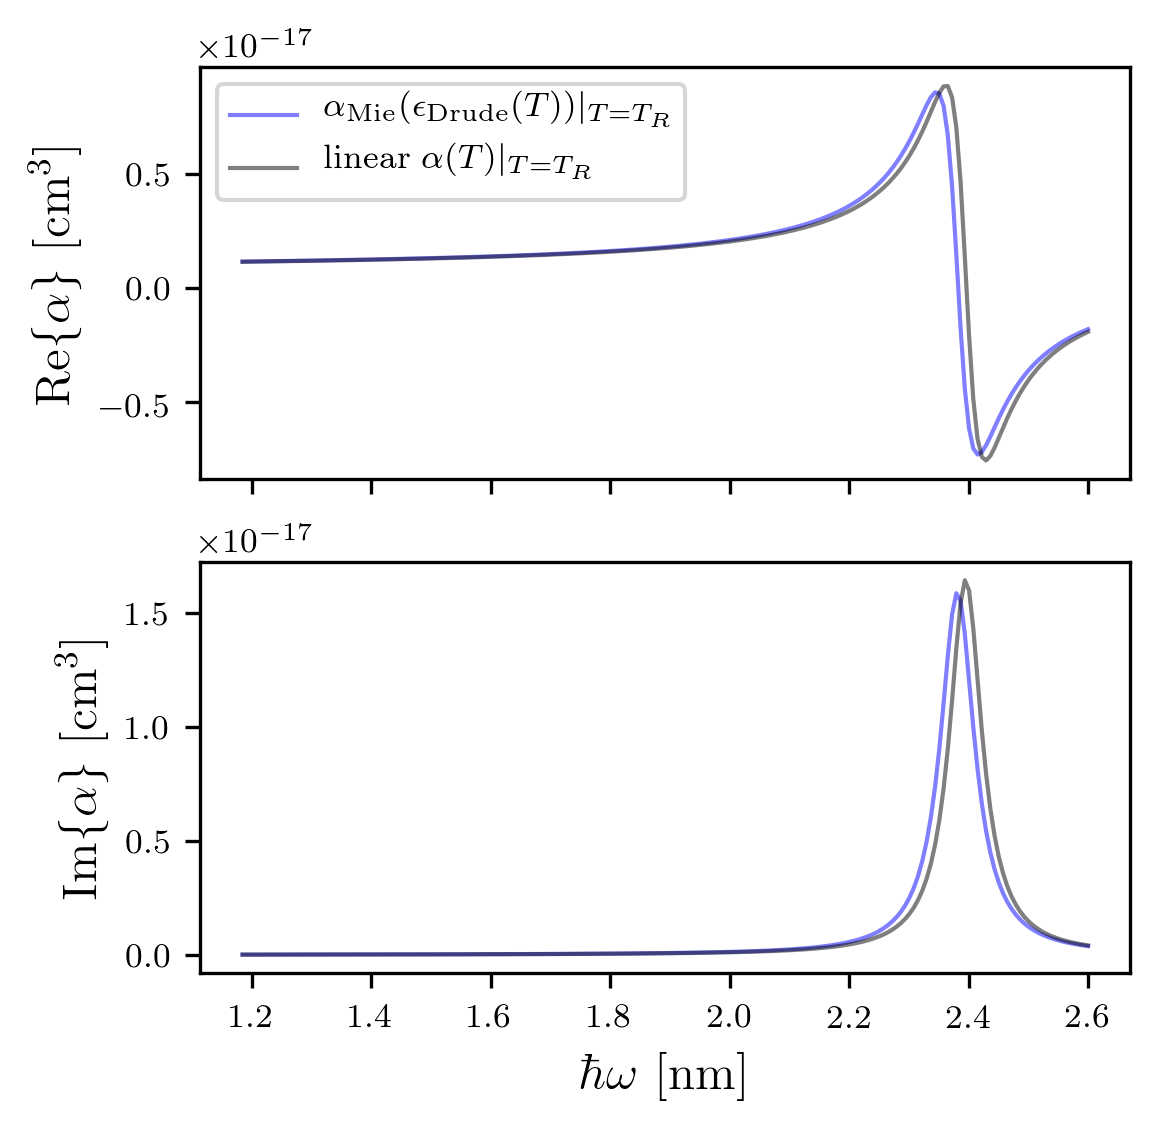

In [31]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

alpha_Drude = alpha_1_of_hw(hw_h)[:, 0,0]

axs[0].plot(
    hw_h, 
    np.real(alpha_Drude), 
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    lw=1,
    c='blue',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(alpha_Drude), 
    lw=1,
    c='blue',  alpha=.5)

axs[0].plot(
    hw_h, 
    np.real(linear_alpha_at0K),
    label=r'linear $\alpha(T)|_{T=T_R}$',
    lw=1,
    c='k',  alpha=.5)
axs[1].plot(
    hw_h, 
    np.imag(linear_alpha_at0K),
    lw=1,
    c='k',  alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$\hbar\omega$ [nm]')
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')

axs[0].legend()



This looks a lot better then I expected. 

### Try different temperatures


Text(0.5, 1.0, '$\\hbar\\omega_\\mathrm{probe} = $ 2.25, or 550 [nm]')

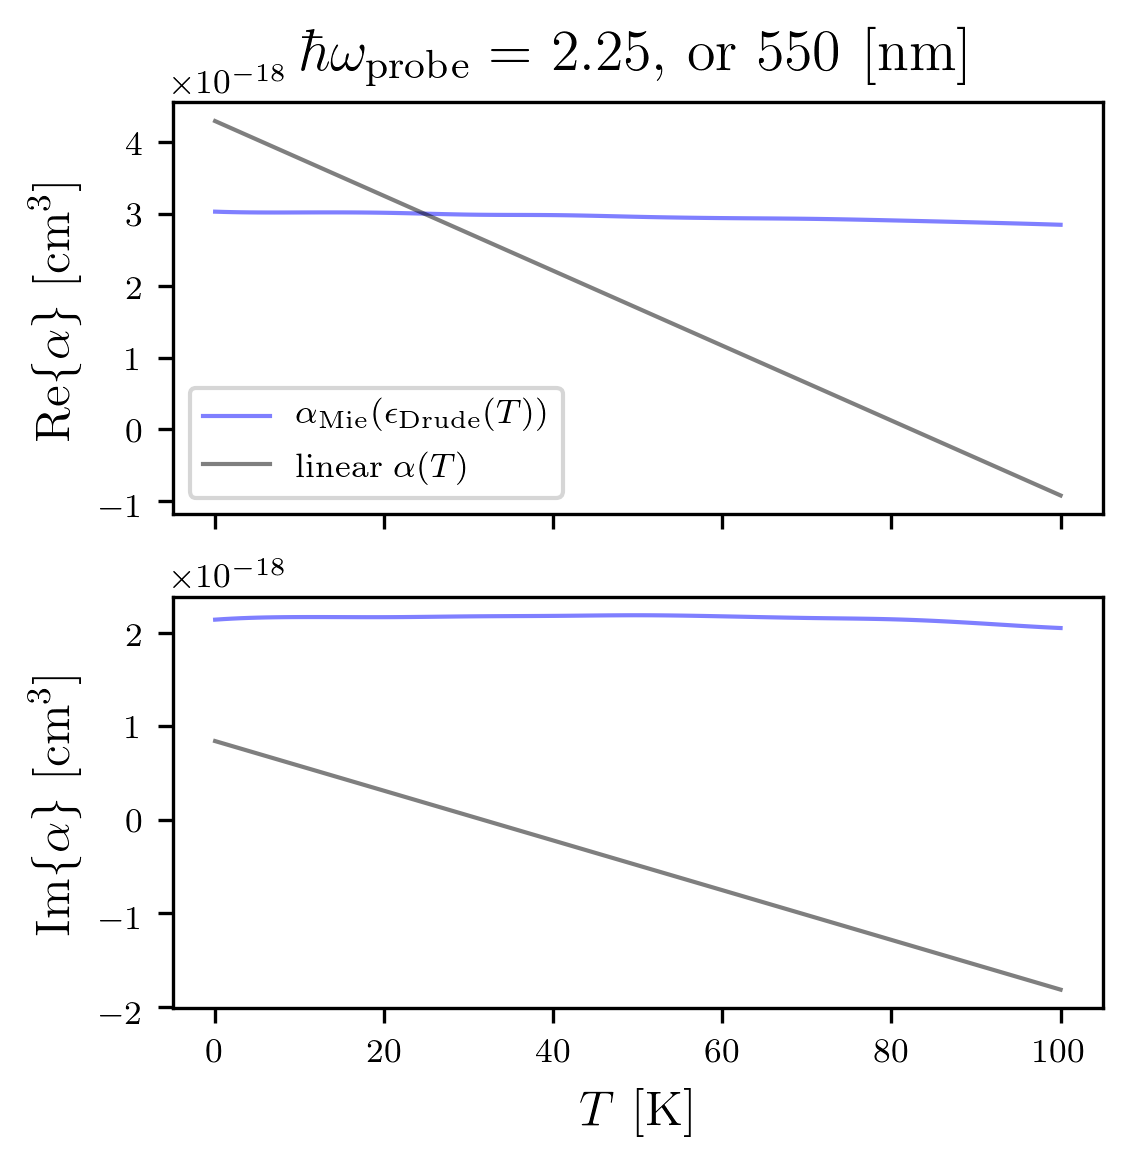

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(4,4))

hw = hw_eps_T_dict[f'hw_eps_0K'][0]

heated_particle = pti.single_particle_image(
    hw.max(), 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag,
    eps0=eps_back)

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)
for i in range(100):
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1][np.argmax(hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw.real.max()/hbar,
        )[0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))$',
    c='blue',  
    alpha=.5)
axs[1].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c='blue',  
    alpha=.5)

axs[0].plot(
    Ts, 
    np.real(alpha_drude), 
    lw=1,
    label=r'linear $\alpha(T)$',
    c='k',  
    alpha=.5)
axs[1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c='k',  
    alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1].set_xlabel(r'$T$ [K]')
axs[0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[0].legend()
axs[0].set_title(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.max().real:.2f}, or {1240/hw.max().real:.0f} [nm]')


In [10]:
hw.max()

(2.2527841869084173+0j)

In [11]:
hw.max()

(2.2527841869084173+0j)

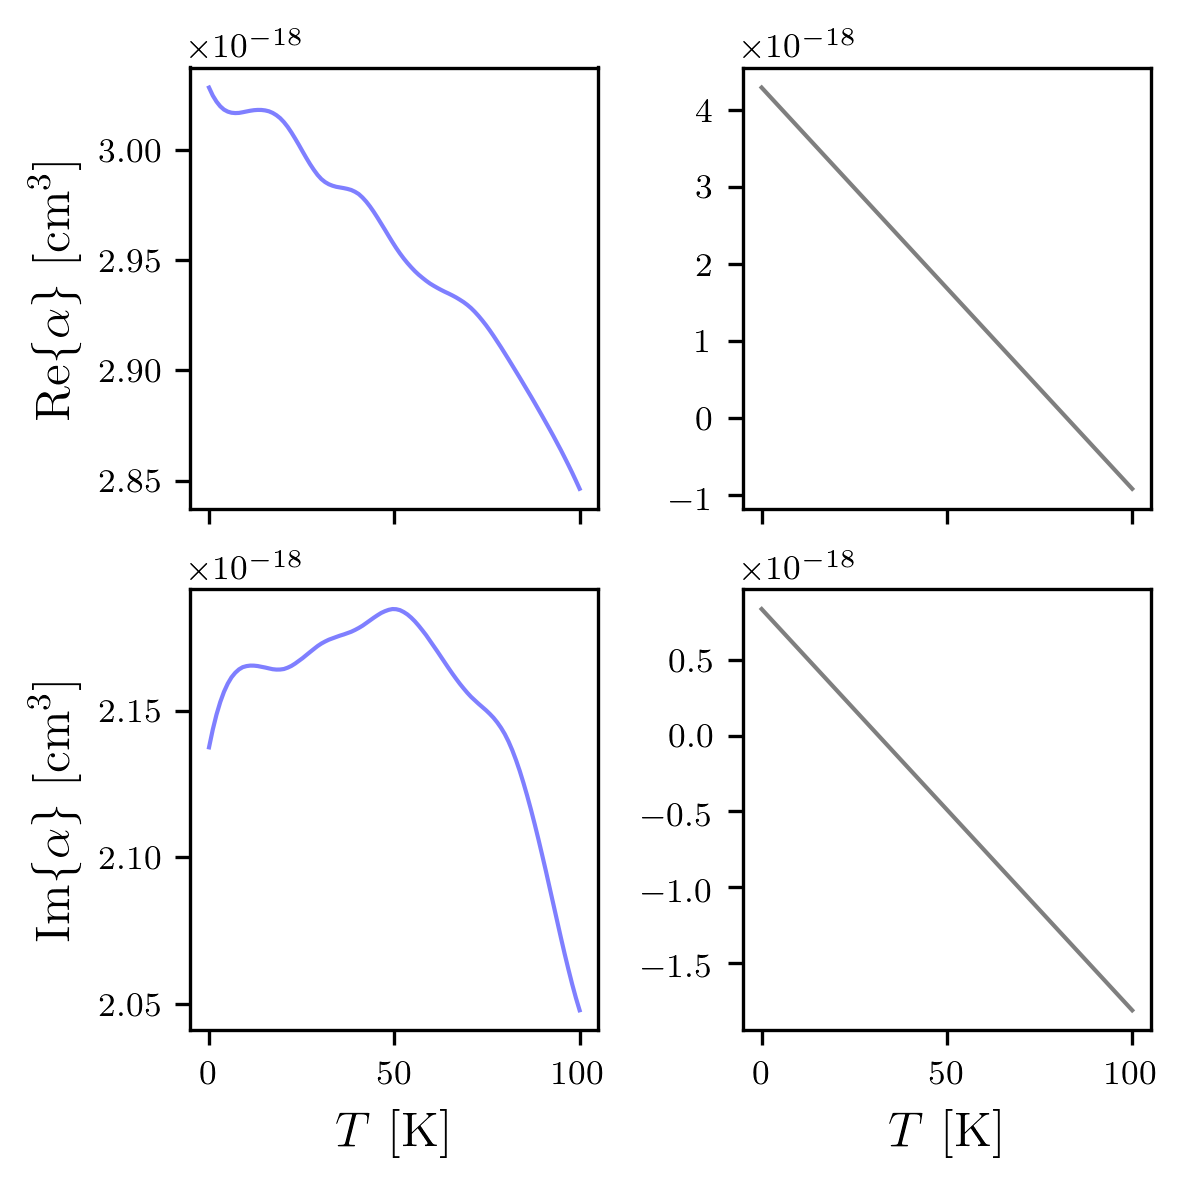

In [12]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(4,4))

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)
for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1][np.argmax(hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw.real.max()/hbar,
        )[0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0, 0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    c='blue',  
    alpha=.5)
axs[1, 0].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c='blue',  
    alpha=.5)

axs[0, 1].plot(
    Ts, 
    np.real(alpha_drude), 
    lw=1,
    label=r'linear $\alpha(T)|_{T=T_R}$',
    c='k',  
    alpha=.5)
axs[1, 1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c='k',  
    alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1, 1].set_xlabel(r'$T$ [K]')
axs[1, 0].set_xlabel(r'$T$ [K]')
axs[0, 0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
plt.tight_layout()


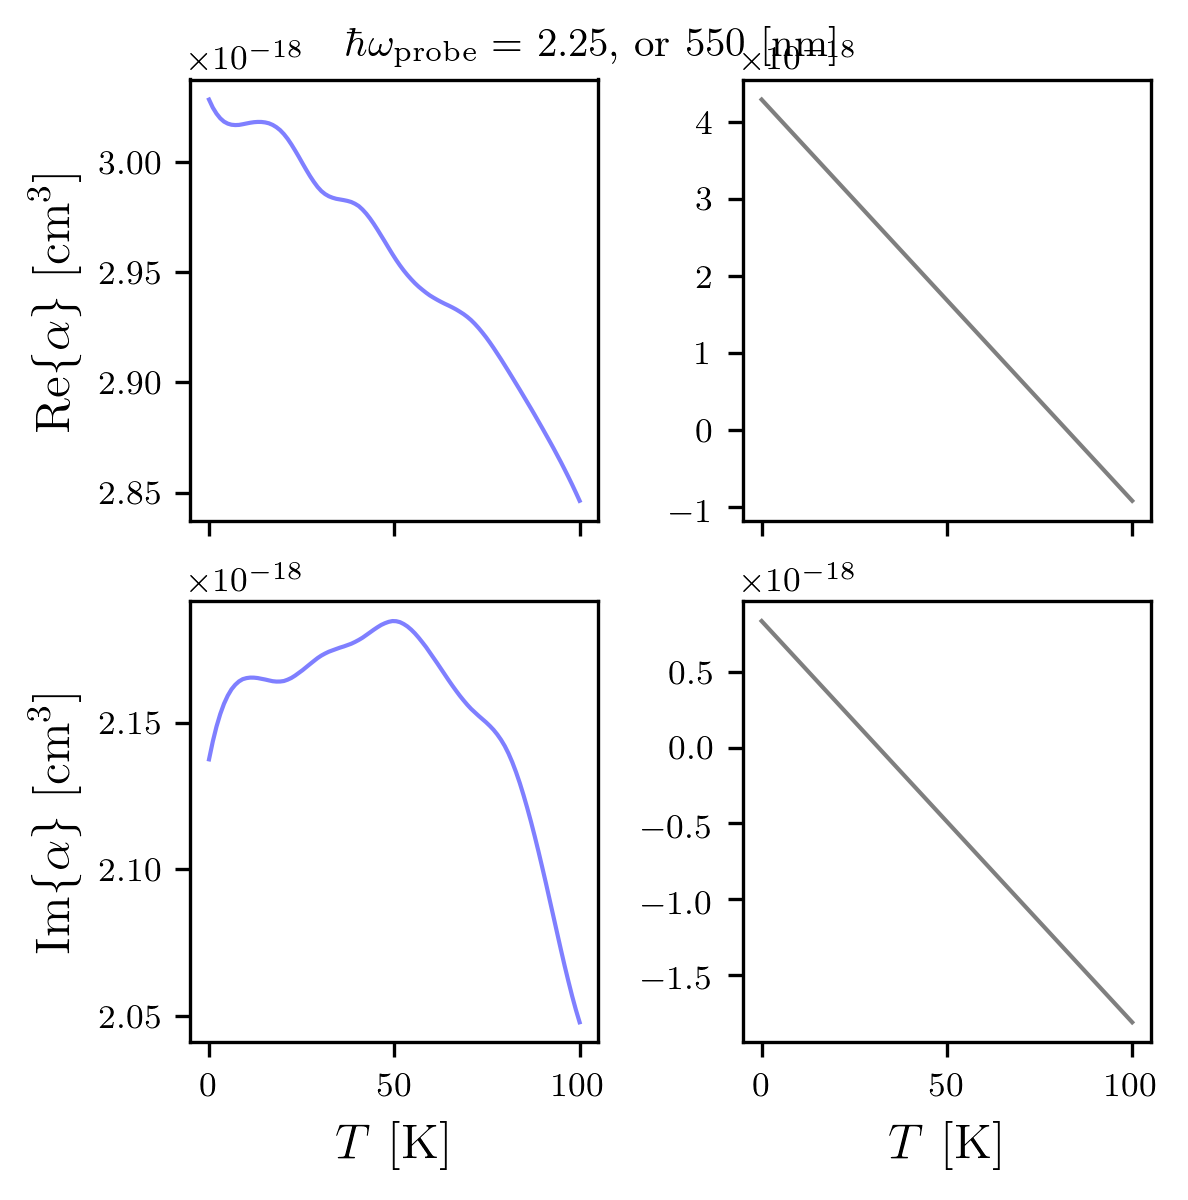

In [13]:
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(4,4))

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)
for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1][np.argmax(hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw.real.max()/hbar,
        )[0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0, 0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    c='blue',  
    alpha=.5)
axs[1, 0].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c='blue',  
    alpha=.5)

axs[0, 1].plot(
    Ts, 
    np.real(alpha_drude), 
    lw=1,
    label=r'linear $\alpha(T)|_{T=T_R}$',
    c='k',  
    alpha=.5)
axs[1, 1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c='k',  
    alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
axs[1, 1].set_xlabel(r'$T$ [K]')
axs[1, 0].set_xlabel(r'$T$ [K]')
axs[0, 0].set_ylabel(r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.max().real:.2f}, or {1240/hw.max().real:.0f} [nm]')

plt.tight_layout()


Real $\alpha$ looks nice and linear, but I have the wrong sign.
Could fit a parabola to Im[$\alpha$], but is that worth it?

In [14]:
## Build a thing to move axis multiplier to label
## https://stackoverflow.com/questions/45760763/how-to-move-the-y-axis-scale-factor-to-the-position-next-to-the-y-axis-label
## -----

# import numpy as np
# import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " (" + fmt.get_offset() + ")" )

## Example
# x = np.arange(5)
# y = np.exp(x)*1e-6

# fig, ax = plt.subplots()
# ax.plot(x,y, marker="d")

# formatter = mticker.ScalarFormatter(useMathText=True)
# formatter.set_powerlimits((-3,2))
# ax.yaxis.set_major_formatter(formatter)

# lo = Labeloffset(ax, label="my label", axis="y")


# plt.show()

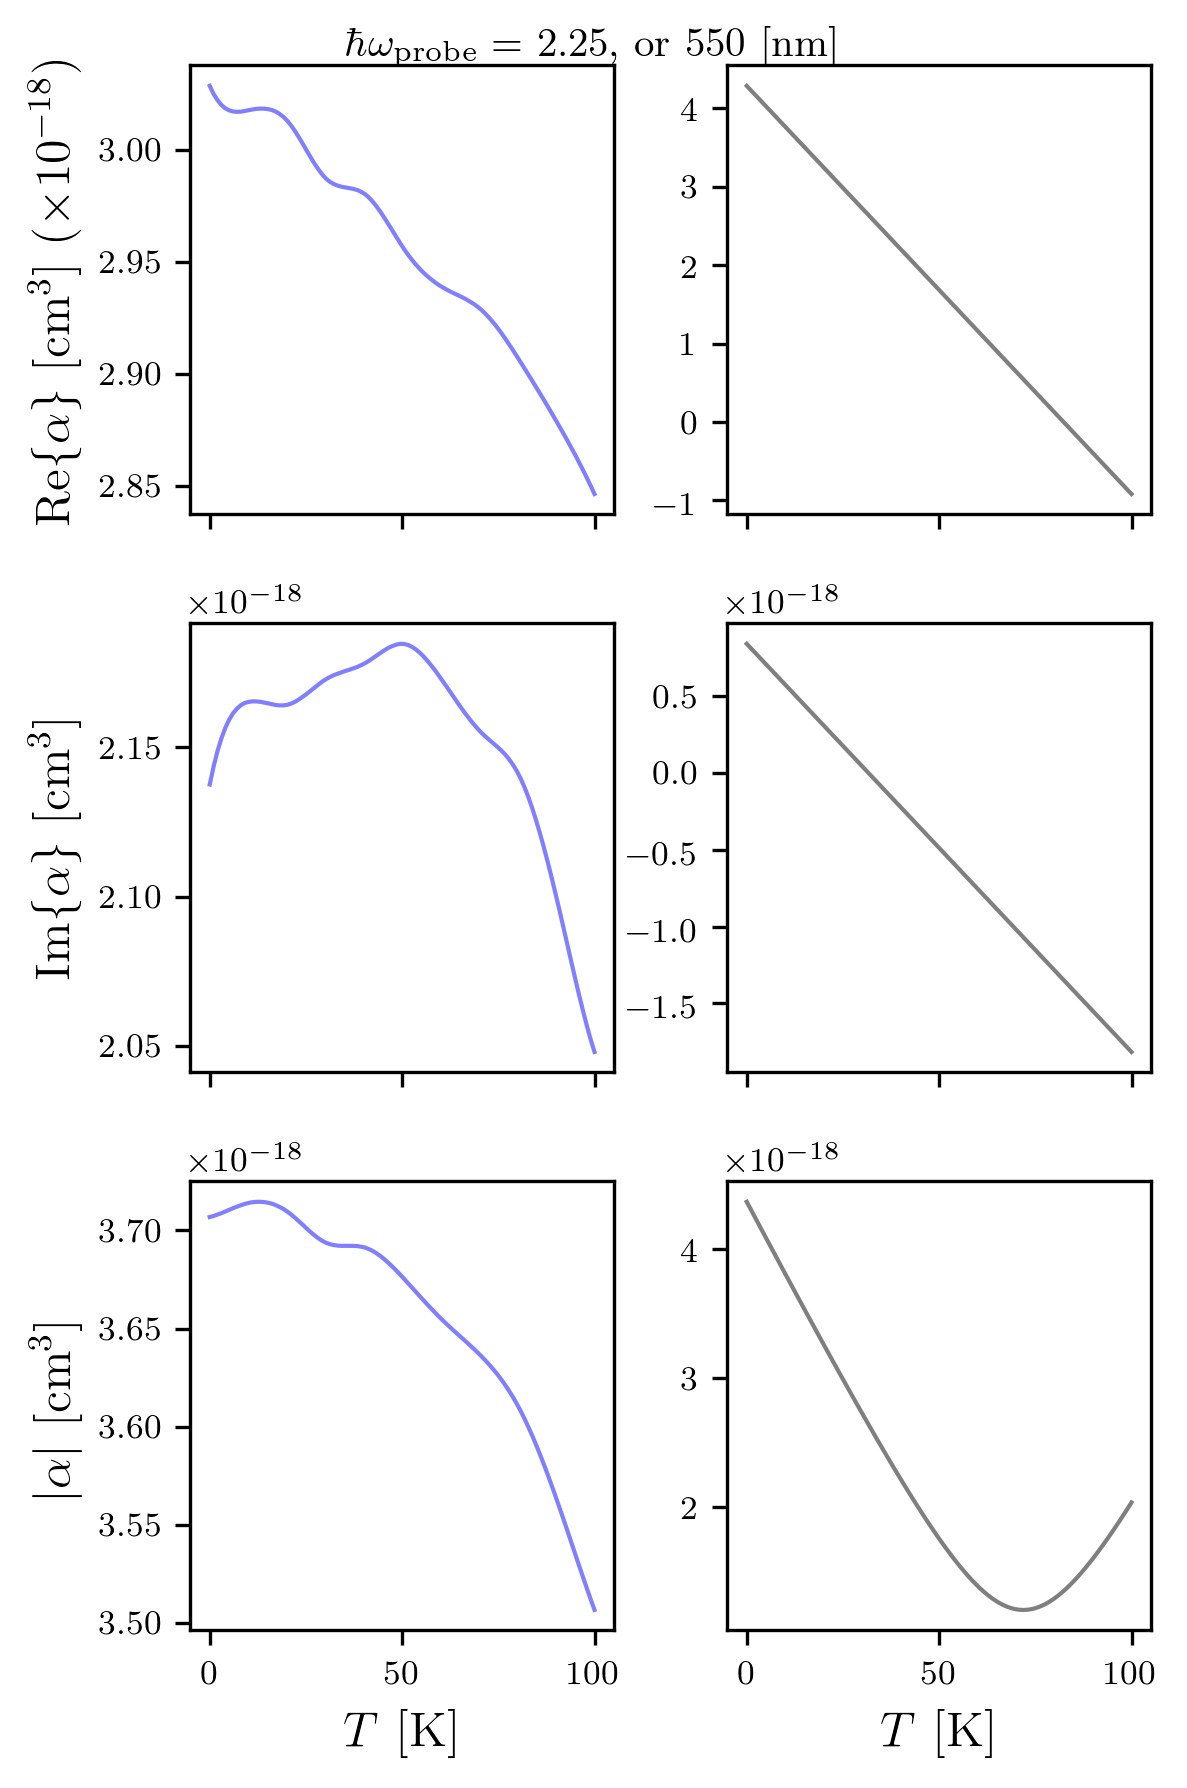

In [15]:
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(4,6))

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)
for i in range(100):
    
    hw = hw_eps_T_dict[f'hw_eps_{i:d}K'][0]
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        hw_eps_T_dict[f'hw_eps_{i:d}K'][1][np.argmax(hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw.real.max()/hbar,
        )[0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0, 0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,
    label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    c='blue',  
    alpha=.5)
axs[1, 0].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c='blue',  
    alpha=.5)
axs[2, 0].plot(
    Ts, 
    np.abs(alpha_mie_epsdata), 
    lw=1,
    c='blue',  
    alpha=.5)

axs[0, 1].plot(
    Ts, 
    np.real(alpha_drude), 
    lw=1,
    label=r'linear $\alpha(T)|_{T=T_R}$',
    c='k',  
    alpha=.5)
axs[1, 1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c='k',  
    alpha=.5)
axs[2, 1].plot(
    Ts, 
    np.abs(alpha_drude), 
    lw=1,
    c='k',  
    alpha=.5)

  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
lo = Labeloffset(axs[0, 0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
axs[0, 1].yaxis.offsetText.set_visible(False)
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2, 0].set_ylabel(r'$|\alpha|$ $[\mathrm{cm}^3]$')

axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2, 0].set_xlabel(r'$T$ [K]')

fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.max().real:.2f}, or {1240/hw.max().real:.0f} [nm]')

plt.tight_layout()


## Compare different frequencies

In [16]:
def idx_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

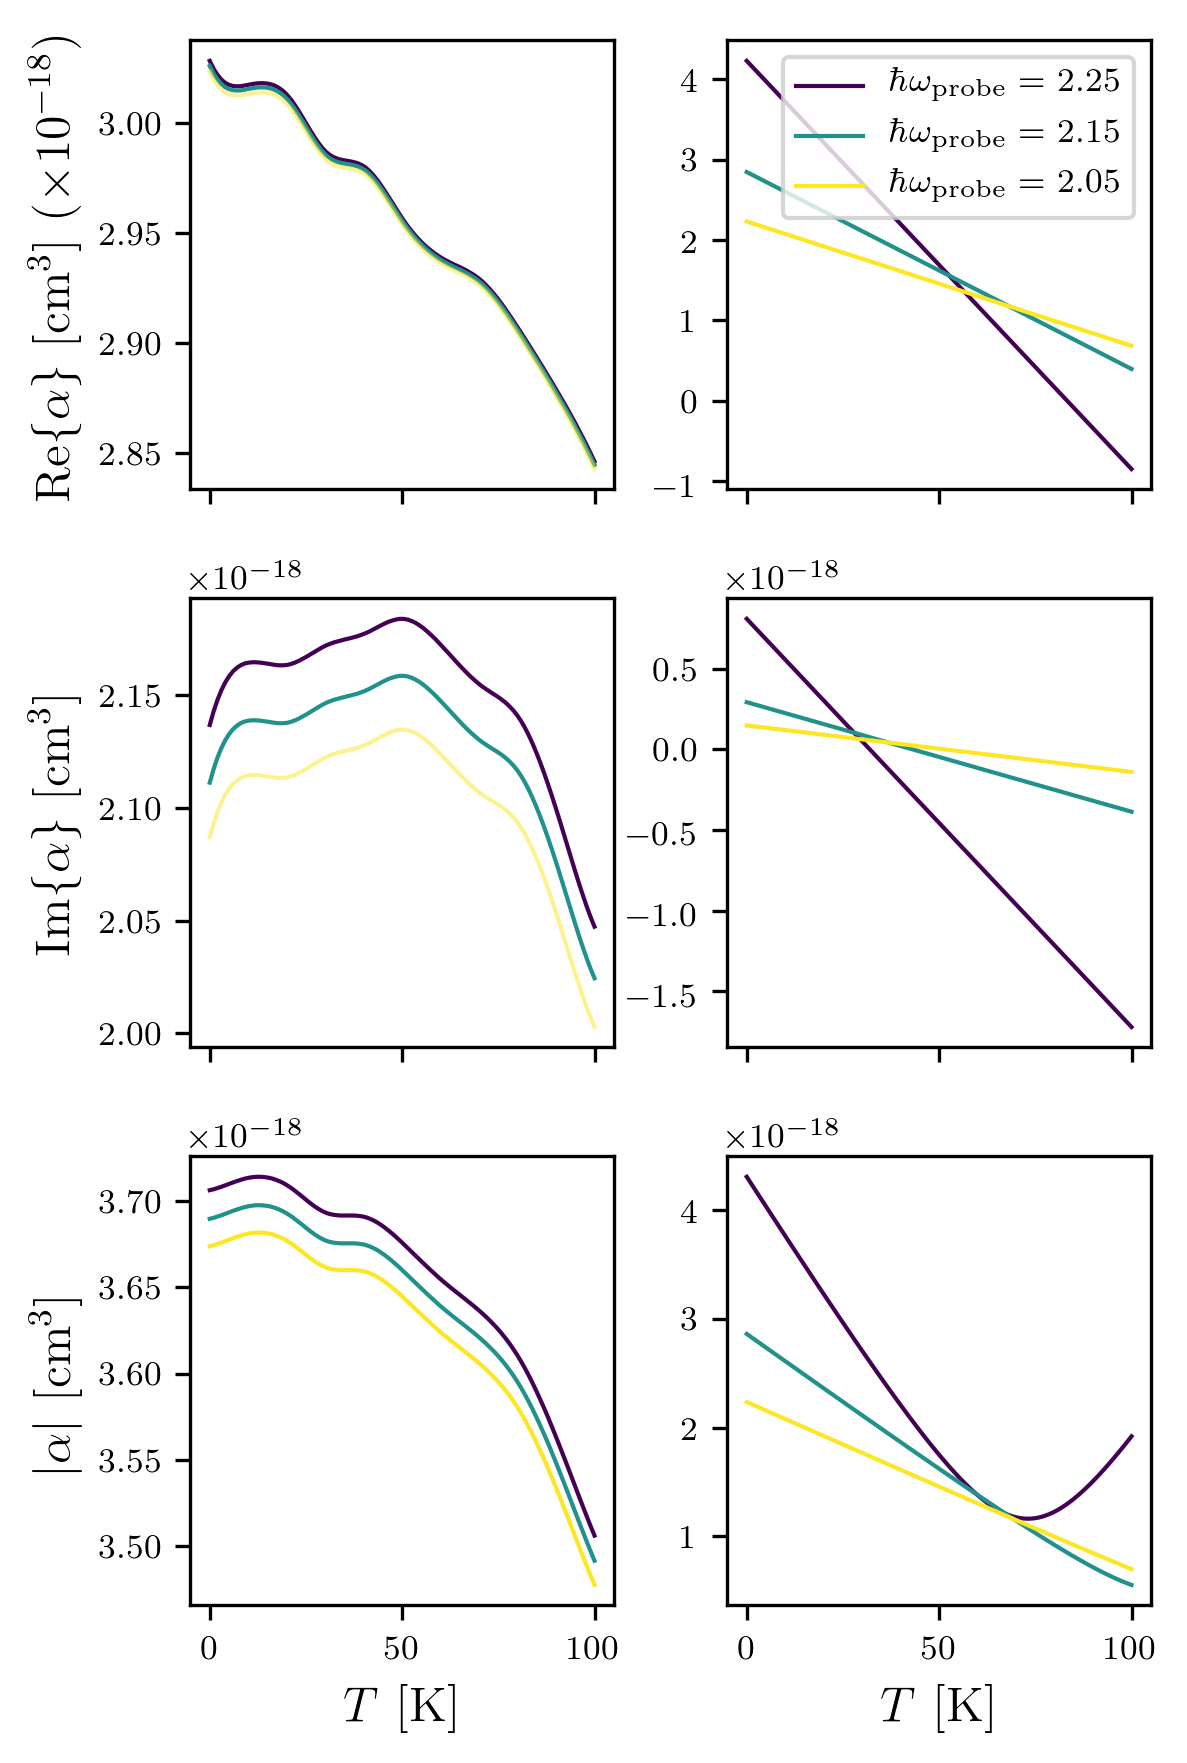

In [17]:
hw = 2.25

heated_particle = pti.single_particle_image(
    hw, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag,
    eps0=eps_back)

fig, axs = plt.subplots(3, 2, sharex=True, figsize=(4,6))

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)

for i in range(100):
        
    eps = hw_eps_T_dict[f'hw_eps_{i:d}K'][1]
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        eps[idx_nearest(eps, hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw/hbar,
        )[ 0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0, 0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,    
#     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    c=mpl.cm.viridis(0/2),  
    )
axs[1, 0].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c=mpl.cm.viridis(0/2),
    )
axs[2, 0].plot(
    Ts, 
    np.abs(alpha_mie_epsdata), 
    lw=1,
    c=mpl.cm.viridis(0/2),
    )

axs[0, 1].plot(
    Ts, 
    np.real(alpha_drude), 
    label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
    lw=1,
#     label=r'linear $\alpha(T)|_{T=T_R}$',
    c=mpl.cm.viridis(0/2),  
    )
axs[1, 1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c=mpl.cm.viridis(0/2),  
    )
axs[2, 1].plot(
    Ts, 
    np.abs(alpha_drude), 
    lw=1,
    c=mpl.cm.viridis(0/2),  
    )

## plot at 2.25
hw = 2.15

heated_particle = pti.single_particle_image(
    hw, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag,
    eps0=eps_back)

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)

for i in range(100):
        
    eps = hw_eps_T_dict[f'hw_eps_{i:d}K'][1]
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        eps[idx_nearest(eps, hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw/hbar,
        )[ 0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0, 0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,
#     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    c=mpl.cm.viridis(1/2),  
    )
axs[1, 0].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c=mpl.cm.viridis(1/2),
    )
axs[2, 0].plot(
    Ts, 
    np.abs(alpha_mie_epsdata), 
    lw=1,
    c=mpl.cm.viridis(1/2),
    )

axs[0, 1].plot(
    Ts, 
    np.real(alpha_drude), 
    label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
    lw=1,
#     label=r'linear $\alpha(T)|_{T=T_R}$',
    c=mpl.cm.viridis(1/2),  
    )
axs[1, 1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c=mpl.cm.viridis(1/2),  
    )
axs[2, 1].plot(
    Ts, 
    np.abs(alpha_drude), 
    lw=1,
    c=mpl.cm.viridis(1/2),  
    )

## plot at 2.25
hw = 2.05

heated_particle = pti.single_particle_image(
    hw, 
    eps_inf=au_eps_inf, 
    w_p=au_w_p,
    gamma=au_gamma,
    E_probe=E_probe_mag,
    eps0=eps_back)

alpha_mie_epsdata = np.zeros(100, dtype='complex' )
alpha_drude = np.zeros_like(alpha_mie_epsdata)
Ts = np.linspace(0, 100, 100)

for i in range(100):
        
    eps = hw_eps_T_dict[f'hw_eps_{i:d}K'][1]
    
    ## Get alpha at highest energy
    alpha_mie_epsdata[i] = cp.sparse_sphere_polarizability_Mie(
        eps[idx_nearest(eps, hw)],
        eps_b=eps_back,
        a=a1*1e-7,
        w=hw/hbar,
        )[ 0,0]

    alpha_drude[i] = heated_particle.alpha_of_T(i, b1*1e-7, a1*1e-7)

axs[0, 0].plot(
    Ts, 
    np.real(alpha_mie_epsdata), 
    lw=1,
#     label=r'$\alpha_\mathrm{Mie}(\epsilon_\mathrm{Drude}(T))|_{T=T_R}$',
    c=mpl.cm.viridis(2/2),  
    alpha=.5,
    )
axs[1, 0].plot(
    Ts, 
    np.imag(alpha_mie_epsdata), 
    lw=1,
    c=mpl.cm.viridis(2/2),
    alpha=.5)
axs[2, 0].plot(
    Ts, 
    np.abs(alpha_mie_epsdata), 
    lw=1,
    c=mpl.cm.viridis(2/2),
    )

axs[0, 1].plot(
    Ts, 
    np.real(alpha_drude), 
    label=r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}',
    lw=1,
#     label=r'linear $\alpha(T)|_{T=T_R}$',
    c=mpl.cm.viridis(2/2),
    )
axs[1, 1].plot(
    Ts, 
    np.imag(alpha_drude), 
    lw=1,
    c=mpl.cm.viridis(2/2),
    )
axs[2, 1].plot(
    Ts, 
    np.abs(alpha_drude), 
    lw=1,
    c=mpl.cm.viridis(2/2),
    )
  
# axs[0].set_ylabel(r'Re[$\alpha(T)/\alpha(0)$]')
# axs[1].set_ylabel(r'Im[$\alpha(T)/\alpha(0)$]')
lo = Labeloffset(axs[0, 0], label=r'$\mathrm{Re}\{\alpha\}$ $[\mathrm{cm}^3]$', axis="y")
axs[0, 1].yaxis.offsetText.set_visible(False)
axs[1, 0].set_ylabel(r'$\mathrm{Im}\{\alpha\}$ $[\mathrm{cm}^3]$')
axs[2, 0].set_ylabel(r'$|\alpha|$ $[\mathrm{cm}^3]$')

axs[2, 1].set_xlabel(r'$T$ [K]')
axs[2, 0].set_xlabel(r'$T$ [K]')

axs[0, 1].legend()
# fig.suptitle(r'$\hbar\omega_\mathrm{probe} = $ '+f'{hw.real:.2f}, or {1240/hw.real:.0f} [nm]')

plt.tight_layout()